In [ ]:
#===============================================================================================
#HPM
#===============================================================================================
 
from gurobipy import *
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt



# === Load dataset ===

# Load only the CUSTOMER section of the text file
data = pd.read_fwf("RC104_25.txt", skiprows=8, header=None)
data.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]


# Load data from previous period
data_pre = pd.read_fwf("RC103_25.txt", skiprows=8, header=None)
data_pre.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]

# === Sets ===
V = list(range(25))  # 25 vehicles
C = list(range(1, len(data)))  # Customers (1 to n), excluding depot (0)
N = list(range(len(data)))  # All nodes including depot

# === Parameters ===
dc = data['DEMAND'].tolist()
dc[0] = 0  # Depot demand = 0
dc_pre = data_pre['DEMAND'].tolist()
dc_pre[0] = 0  # Depot demand = 0
coords = list(zip(data['XCOORD'], data['YCOORD']))
ai = data['READY_TIME'].tolist()
bi = data['DUE_DATE'].tolist()
si = data['SERVICE_TIME'].tolist()

# Problem parameters
cij = 30
delta = 0.17        #https://progresschamber.org/wp-content/uploads/2024/06/Chamber-of-Progress-Efficiency-and-Emissions-Impact-of-Last-Mile-Online-Delivery-in-the-US.pdf
lambda_v = 200
pi = 10
theta = 0.7
mv = 100000
cv = 100
hv = 15
ev = 0.1
cf = 0.5                                                                                        
fv = 0.1
M = 1000000
w1, w2, w3 = 1, 1, 1  # weight for objectives

dc_rev = [round(d * delta) for d in dc_pre]  # Integer reverse demand!!!!

# === Distance matrix ===
t = np.zeros((len(N), len(N)))
for i in N:
    for j in N:
        t[i][j] = math.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])

# === Build model function ===
def build_base_model():
    m = Model()
    x = m.addVars(N, N, V, vtype=GRB.BINARY, name="x")
    z = m.addVars(N, V, vtype=GRB.BINARY, name="z")
    y = m.addVars(V, vtype=GRB.BINARY, name="y")  
    L0 = m.addVars(V, vtype=GRB.CONTINUOUS, name="L0")
    L = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="L")
    alpha = m.addVars(N, V, vtype=GRB.CONTINUOUS, name="alpha")
    beta = m.addVars(V, vtype=GRB.CONTINUOUS, name="beta")
    Fc = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="Fc")
    Rc = m.addVars(C, V, vtype=GRB.CONTINUOUS, name="Rc")
    Qd = m.addVars(C, vtype=GRB.CONTINUOUS, name="Qd")
    Qr = m.addVars(C, vtype=GRB.CONTINUOUS, name="Qr")

    # === Constraints ===
    
    # Vehicle only depart from the depot if it is used
    for v in V:
        m.addConstr(quicksum(x[0, j, v] for j in N) == y[v], name='depart_%s' % v)
        
    # Vehicle only depart from the depot if it is used
    for v in V:
        m.addConstr(quicksum(x[i, 0, v] for i in N) == y[v], name='finish_%s' % v)
    
    # Vehicle can be used or not
    for v in V:
        m.addConstr(y[v] <= 1, name='usedORnot_%s' % v)

    # Flow conservation, vehicle enter node and must exit
    for v in V:
        for i in N:
            m.addConstr(quicksum(x[i, j, v] for j in N) == quicksum(x[j, i, v] for j in N), name='FlowConservation_%s_%s' % (i, v))
    
    # No self-loop on customer nodes 
    for v in V:
        for i in C:
            m.addConstr(x[i, i, v] == 0, 
                    name='NoSelfLoop_%s_%s' % (i, v)) 

    # Each destination node is visited from nodes that previously visited
    for v in V:
        for i in N:
            m.addConstr(quicksum(x[i, j, v] for j in N) == z[i, v], 
                    name='Visit_%s_%s' % (i, v))     
    
    # Each customer node can be visited by different vehicles
    for i in C: 
        m.addConstr(quicksum(z[i, v] for v in V) >= 1, 
                name='MultiVisit_%s' % i)
    
    # Customer forward demand may not be fully satisfied in each period
    for i in C:
        m.addConstr(quicksum(Fc[i, v] for v in V) + Qd[i] >= dc[i], 
                name='forward_%s' % i)
    
    # Customer forward demand is not served if vehicle does not visit 
    for i in C:
        for v in V:
            m.addConstr(Fc[i,v] <= dc[i] * z[i,v], name=f"FlowIfVisit_{i}_{v}")

    # Customer reverse demand which depends on the forward demand of the previous period may not be fully satisfied in current period 
    for i in C:
        m.addConstr(quicksum(Rc[i, v] for v in V) + Qr[i] >= dc_rev[i], 
                name='return_%s' % i)
    
    # Customer reverse demand is not served if vehicle does not visit 
    for i in C:
        for v in V:
            m.addConstr(Rc[i,v] <= dc_rev[i] * z[i,v], name=f"ReturnIfVisit_{i}_{v}")

    # Each initial vehicle load is the accumulated demand of all customer points assigned to this vehicle
    for v in V:
        m.addConstr(L0[v] >= quicksum(Fc[i, v] for i in C), 
                name='startload_%s' % v)
    
    # Ensure the load balance of vehicles after they visit each customer point on their route
    for v in V:
        for i in C:
            for j in C:
                if i != j:
                    m.addConstr(L[j, v] >= L[i, v] - Fc[j, v] + Rc[j, v] - M * (1 - x[i, j, v]), name='otherload_%s_%s_%s' % (i, j, v))
    
    # The initial vehicle load doesn't exceed capacity of vehicle
    for v in V:
        m.addConstr(L0[v] <= lambda_v, 
                name='startcap_%s' % v)
    
    # The vehicle load after serving each customer doesn't exceed capacity of vehicle
    for v in V:
        for i in C:
            m.addConstr(L[i, v] <= lambda_v * z[i, v], 
                name='othercap_%s_%s' % (i, v))

    # Start of service time of destination node is after origin node and service duration    
    for v in V:
        for i in N:
            for j in C:
                m.addConstr(alpha[j, v] >= alpha[i, v] + si[i] + t[i][j] - M * (1 - x[i, j, v]), name='starttime_%s_%s_%s' % (i, j, v))
    
    # Time window constraints start of service time inside time window
    for v in V:
        for i in N:
            m.addConstr(alpha[i, v] >= ai[i] * z[i, v], 
                    name='EarliestStart_%s_%s' % (i, v)) 
            m.addConstr(alpha[i, v] <= bi[i] + M * (1 - z[i, v]), 
                    name='LatestStart_%s_%s' % (i, v)) 
    
    # Total duration that each vehicle finishes all services
    for v in V:
        m.addConstr(beta[v] == quicksum(t[i][j] * x[i, j, v] for i in N for j in C) + quicksum(si[i] * x[i, j, v] for i in C for j in C), 
                name='totalhour_%s' % v)
    
    # The maximum allowed transportation duration limit for each vehicle
    for v in V  :
        m.addConstr(beta[v] <= mv, 
                name='maxhour_%s' % v)

    return m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc

In [2]:
# === Solve single-objective functions ===
def solve_feco_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Feco = quicksum(hv * beta[v] + cv * y[v] for v in V) + \
           quicksum(t[i][j] * x[i, j, v] * (cf * fv + cij) for i in N for j in N for v in V if i != j) + \
           pi * quicksum(Qd[i] + (1 - theta) * Qr[i] for i in C)
    m.setObjective(Feco, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('eco25.lp')
    m.optimize()
    m.write('eco25.sol')
    return m.objVal

# === Retrieve best values ===
Feco_best = solve_feco_best()

print("\n=== Best Objective Values ===")
print(f"Best Economic Cost (Feco_best): {Feco_best:.4f}")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x6caf703a
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [3e+00, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 2925 rows and 2400 columns
Presolve time: 1.61s
Presolved: 33675 rows, 17800 columns, 314150 nonzeros
Variable types: 2550 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time:

In [3]:
# === Solve single-objective functions ===

def solve_fenv_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Fenv = quicksum(ev * t[i][j] * x[i, j, v] for i in N for j in N for v in V if i != j)
    m.setObjective(Fenv, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('env25.lp')
    m.optimize()
    m.write('env25.sol')
    return m.objVal

# === Retrieve best values ===
Fenv_best = solve_fenv_best()

print("\n=== Best Objective Values ===")
print(f"Best Environmental Impact (Fenv_best): {Fenv_best:.4f}")

Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x25d7e601
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 4200 rows and 3075 columns
Presolve time: 4.97s
Presolved: 32400 rows, 17125 columns, 277707 nonzeros
Variable types: 1875 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.4958229e+01 

In [4]:
# === Solve single-objective functions ===

def solve_fsoc_best():
    m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()
    Fsoc = quicksum(beta[v] for v in V)
    m.setObjective(Fsoc, GRB.MINIMIZE)
    m.Params.timeLimit = 900
    m.update()
    m.write('soc25.lp')
    m.optimize()
    m.write('soc25.sol')
    return m.objVal

# === Retrieve best values ===
Fsoc_best = solve_fsoc_best()

print("\n=== Best Objective Values ===")
print(f"Best Social Cost (Fsoc_best): {Fsoc_best:.4f}")

Set parameter TimeLimit to value 900
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x66631c84
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]
Presolve removed 4200 rows and 3075 columns
Presolve time: 1.27s
Presolved: 32400 rows, 17125 columns, 277707 nonzeros
Variable types: 1875 continuous, 15250 integer (15250 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic s

In [3]:
# === Final full model ===
m, x, y, z, alpha, beta, Qd, Qr,Fc,Rc = build_base_model()

Feco_best = 18390.9967         # input best values as parameters !!!
Fenv_best = 30.4283            # input best values as parameters !!!
Fsoc_best = 411.1106          # input best values as parameters !!!

Feco = quicksum(hv * beta[v] + cv * y[v] for v in V) + \
       quicksum(t[i][j] * x[i, j, v] * (cf * fv + cij) for i in N for j in N for v in V if i != j) + \
       pi * quicksum(Qd[i] + (1 - theta) * Qr[i] for i in C)

Fenv = quicksum(ev * t[i][j] * x[i, j, v] for i in N for j in N for v in V if i != j)
Fsoc = quicksum(beta[v] for v in V)
Fsat = quicksum(theta * Qd[i] + (1 - theta) * Qr[i] for i in C)

F1 = w1 * (Feco - Feco_best) / Feco_best + \
     w2 * (Fenv - Fenv_best) / Fenv_best + \
     w3 * (Fsoc - Fsoc_best) / Fsoc_best

m.setObjectiveN(F1, index=0, priority=1, name="Sustainability")
m.setObjectiveN(Fsat, index=1, priority=0, name="CustomerSatisfaction")

# === Solve ===
m.update()
m.write('VRPmodel.lp')
m.Params.timeLimit = 300
m.optimize()
m.write('VRPmodel.sol')


print("Final Objective Values:")
print("Feco:", Feco.getValue())
print("Fenv:", Fenv.getValue())
print("Fsoc:", Fsoc.getValue())
print("Customer Satisfaction (Fsat):", Fsat.getValue())

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-20
Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11370H @ 3.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 36600 rows, 20200 columns and 199350 nonzeros
Model fingerprint: 0x8b7e9eae
Variable types: 2625 continuous, 17575 integer (17575 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [2e-04, 7e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
----------------------------

In [4]:
import json
# === Extract ordered routes directly for metaheuristics ===
def extract_ordered_routes(x, y, V, N):
    routes = [[] for _ in V]
    arc_solution = m.getAttr('x', x)

    for v in V:
        if y[v].X > 0.5:
            next_node = {i: j for (i, j, vv) in arc_solution if vv == v and arc_solution[i, j, v] > 0.5}
            route = [0] 
            current = 0
            visited = set([0])

            while current in next_node and next_node[current] not in visited:
                current = next_node[current]
                route.append(current)
                visited.add(current)

            routes[v] = route
    return routes

# === Usage ===
initial_routes = extract_ordered_routes(x, y, V, N)
print(initial_routes)

# Export to file
with open("routes.json", "w") as f:
    json.dump(initial_routes, f)

[[], [], [], [0, 2, 6, 7, 8, 4, 5, 3, 1], [], [], [], [0, 12, 14, 15, 11, 10, 9, 13, 16, 17], [], [], [], [0, 24, 22, 18, 21, 23, 25, 19, 20], [], [], [], [], [], [], [], [], [], [], [], [], []]


No optimal solution found.

z[i, v] for Vehicle 3:
  Node 0: 1.00
  Node 1: 1.00
  Node 2: 1.00
  Node 3: 1.00
  Node 4: 1.00
  Node 5: 1.00
  Node 6: 1.00
  Node 7: 1.00
  Node 8: 1.00

z[i, v] for Vehicle 7:
  Node 0: 1.00
  Node 9: 1.00
  Node 10: 1.00
  Node 11: 1.00
  Node 12: 1.00
  Node 13: 1.00
  Node 14: 1.00
  Node 15: 1.00
  Node 16: 1.00
  Node 17: 1.00

z[i, v] for Vehicle 11:
  Node 0: 1.00
  Node 18: 1.00
  Node 19: 1.00
  Node 20: 1.00
  Node 21: 1.00
  Node 22: 1.00
  Node 23: 1.00
  Node 24: 1.00
  Node 25: 1.00

=== Forward Demand Fc[i, v] (Only Used Vehicles) ===
Vehicle 3 Forward Demand (Fc):
  Customer 1: 20.00
  Customer 2: 30.00
  Customer 3: 10.00
  Customer 4: 40.00
  Customer 5: 20.00
  Customer 6: 20.00
  Customer 7: 20.00
  Customer 8: 10.00

Vehicle 7 Forward Demand (Fc):
  Customer 9: 20.00
  Customer 10: 30.00
  Customer 11: 40.00
  Customer 12: 20.00
  Customer 13: 10.00
  Customer 14: 10.00
  Customer 15: 20.00
  Customer 16: 20.00
  Customer 17: 20.00

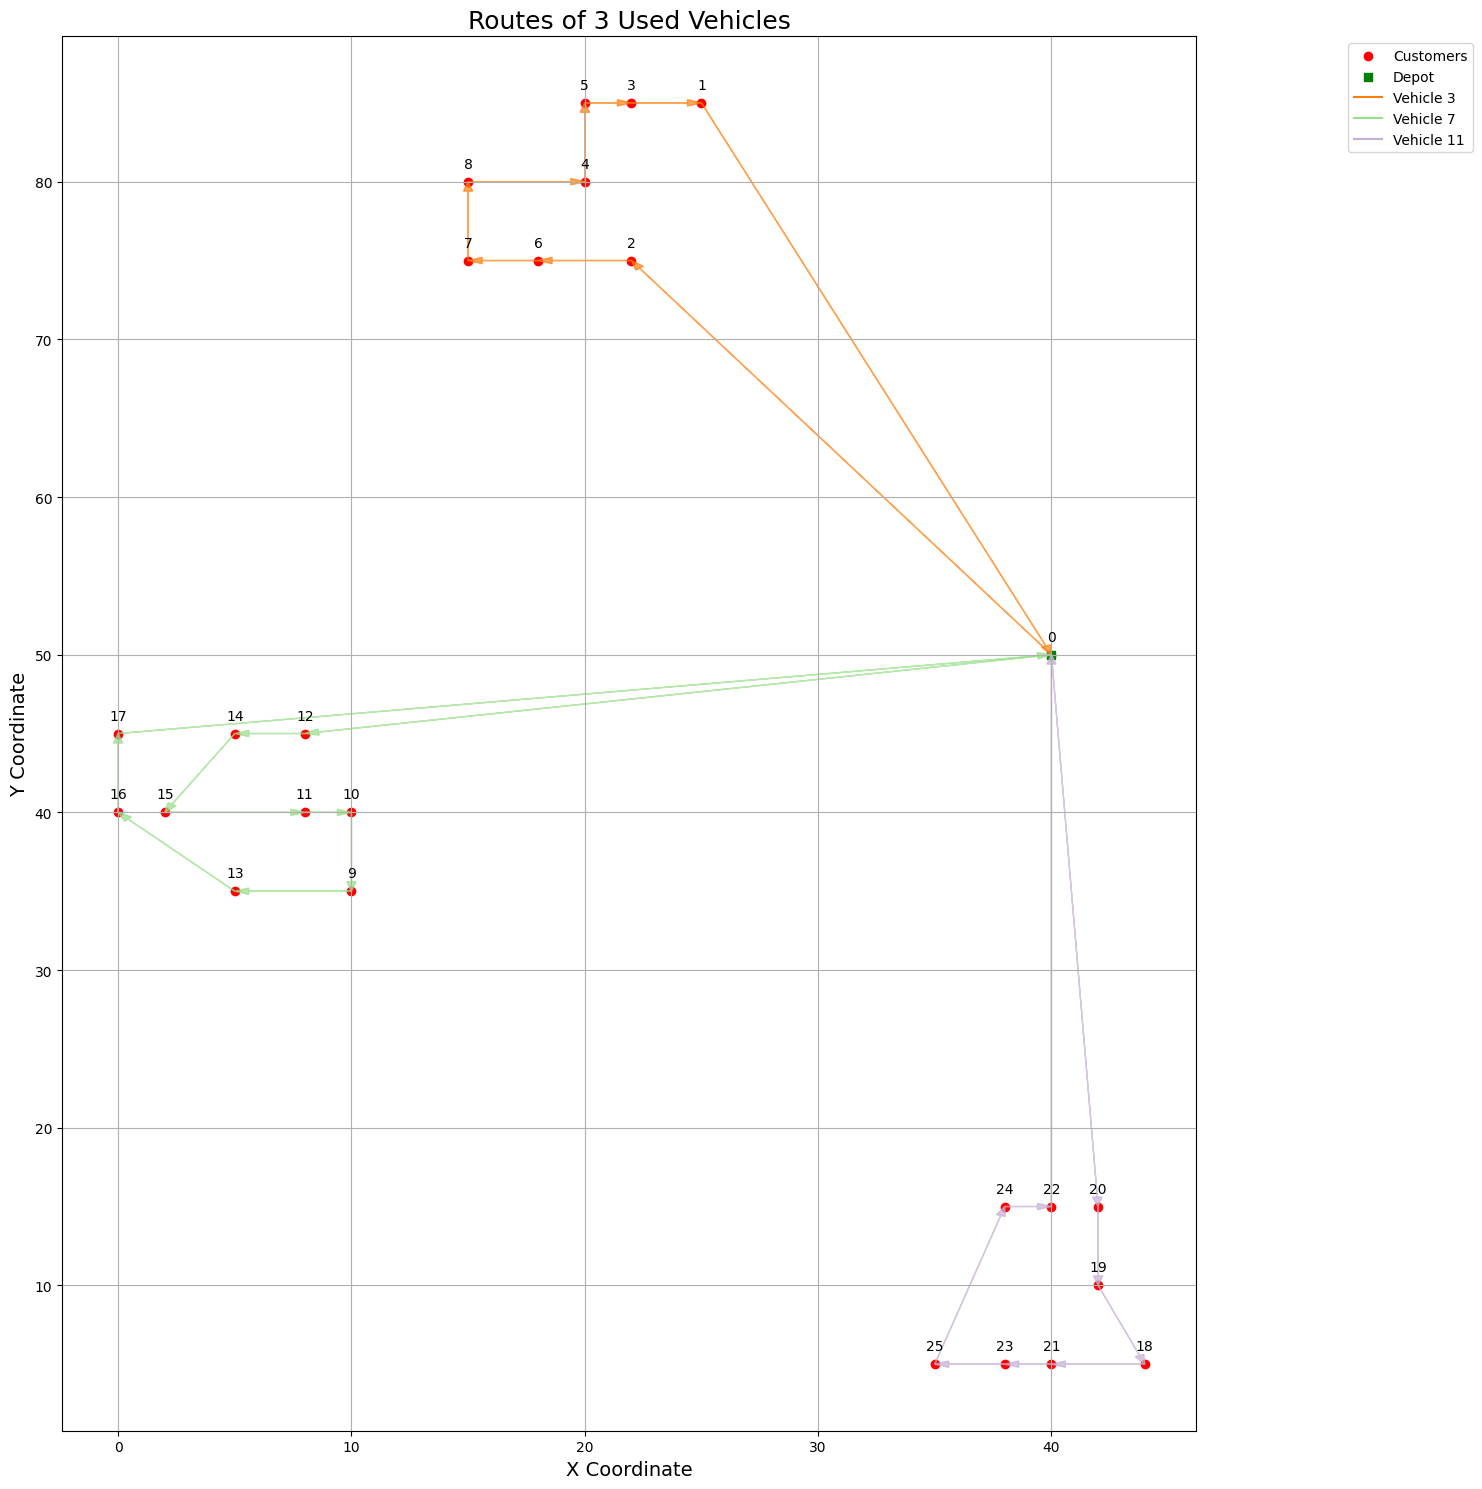

In [3]:
# === Output ===
if m.status == GRB.OPTIMAL:
    print("Optimal solution found.")
else:
    print("No optimal solution found.")

# === Routing matrix x[i,j,v], only for used vehicles ===
#arc_solution = m.getAttr('x', x)
#for v in V:
#    if y[v].X > 0.5:  # Only print for used vehicles
#        print(f"\nRouting matrix x[i,j,v] for Vehicle {v}:")
#        header = "     " + "   ".join([f"{j:>5}" for j in N])  
#        print(header)
#        print("-" * len(header))  
#        for i in N:
#            row = [f"{arc_solution[i, j, v]:>5.2f}" for j in N]  
#            print(f"{i:>5}  " + "   ".join(row))  

# === z[i, v] matrix ===
for v in V:
    if y[v].X > 0.5:
        print(f"\nz[i, v] for Vehicle {v}:")
        for i in N:
            if z[i, v].X > 1e-4:
                print(f"  Node {i}: {z[i, v].X:.2f}")

# === Forward Demand Fc[i, v] ===
print("\n=== Forward Demand Fc[i, v] (Only Used Vehicles) ===")
for v in V:
    if y[v].X > 0.5:
        print(f"Vehicle {v} Forward Demand (Fc):")
        for i in C:
            val = Fc[i, v].X
            if val > 1e-4:
                print(f"  Customer {i}: {val:.2f}")
        print()

# === Reverse Demand Rc[i, v] ===
print("\n=== Reverse Demand Rc[i, v] (Only Used Vehicles) ===")
for v in V:
    if y[v].X > 0.5:
        print(f"Vehicle {v} Reverse Demand (Rc):")
        for i in C:
            val = Rc[i, v].X
            if val > 1e-4:
                print(f"  Customer {i}: {val:.2f}")
        print()

# === Service times and cumulative demand ===
routes = {v: [] for v in V}
for v in V:
    if y[v].X > 0.5:
        for i in N:
            for j in N:
                if x[i, j, v].X > 0.5:
                    routes[v].append((i, j))

        print(f"Vehicle {v} Service Times and Cumulative Demand:\n")
        print(f"{'Node':<8}{'Service Start Time':<20}{'Cumulative Demand':<20}")
        print("-" * 50)
        
        cumulative_demand = 0
        visited = set()
        sorted_routes = sorted(routes[v], key=lambda x: alpha[x[0], v].X)
        
        for (i, j) in sorted_routes:
            if i != 0 and i not in visited:
                visited.add(i)
                cumulative_demand += Fc[i, v].X
                print(f"{i:<8}{alpha[i, v].X:<20.2f}{cumulative_demand:<20.2f}")
        print()


#========================================PLOT========================================
# Plot the routes
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Coordinates
xc = [c[0] for c in coords]
yc = [c[1] for c in coords]

plt.figure(figsize=(15, 15))
plt.scatter(xc, yc, c='red', label='Customers')
plt.scatter(xc[0], yc[0], c='green', marker='s', label='Depot')

for i, (x, y_) in enumerate(zip(xc, yc)):
    plt.annotate(str(i), (x, y_), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

# Color map for up to 25 vehicles
cmap = plt.get_cmap('tab20', len(V))
used_vehicle_count = 0

for v in V:
    if y[v].X > 0.5:
        used_vehicle_count += 1
        color = cmap(v % 20)  # Cycle through 20 colors
        for (i, j) in routes[v]:
            plt.arrow(xc[i], yc[i], xc[j] - xc[i], yc[j] - yc[i],
                      color=color, head_width=0.4, length_includes_head=True, alpha=0.7)

        # Add label only once per vehicle
        plt.plot([], [], color=color, label=f'Vehicle {v}')

plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.title(f'Routes of {used_vehicle_count} Used Vehicles', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()




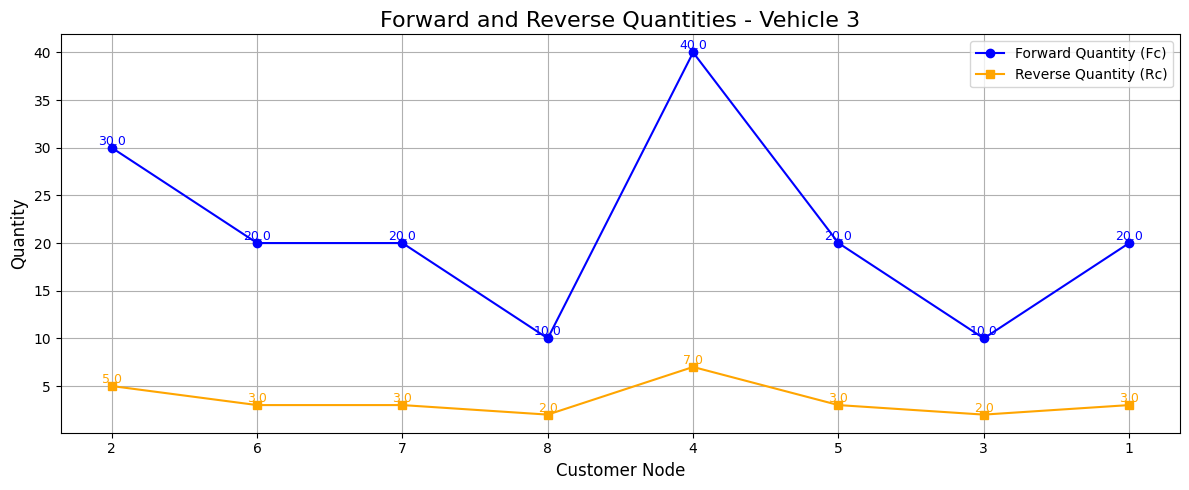

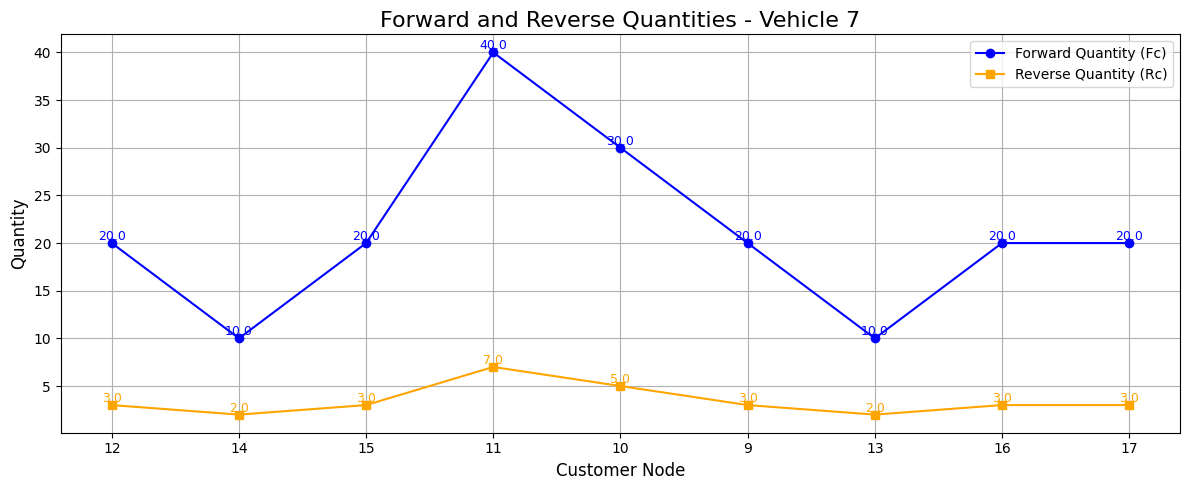

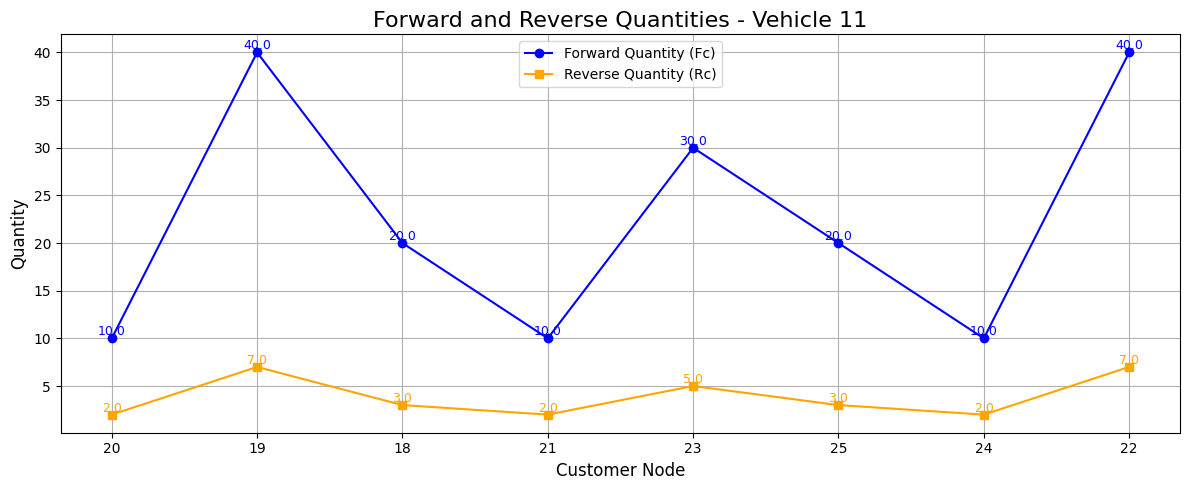

In [4]:
# === Chart ===
import matplotlib.pyplot as plt

for v in V:
    route = [i for (i, j) in sorted(routes[v], key=lambda x: alpha[x[0], v].X) if i in C]
    if len(route) == 0:
        continue

    forward_q = [Fc[i, v].X for i in route]
    reverse_q = [Rc[i, v].X for i in route]
    nodes = [str(i) for i in route]

    plt.figure(figsize=(12, 5))
    plt.plot(nodes, forward_q, marker='o', label='Forward Quantity (Fc)', color='blue')
    plt.plot(nodes, reverse_q, marker='s', label='Reverse Quantity (Rc)', color='orange')

    # Annotate points with values
    for idx, val in enumerate(forward_q):
        plt.text(nodes[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
    for idx, val in enumerate(reverse_q):
        plt.text(nodes[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='orange')

    plt.title(f'Forward and Reverse Quantities - Vehicle {v}', fontsize=16)
    plt.xlabel('Customer Node', fontsize=12)
    plt.ylabel('Quantity', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [5]:
# === Update dataset for next period ===

data_updated = data.copy()

num_customers = len(C)

# === Aggregate total satisfied forward demand per customer (sum over all vehicles) ===
Fc_total = []
for i in C:
    total_fc = sum(Fc[i, v].X for v in V)
    Fc_total.append(total_fc)

# === Collect unsatisfied demands ===
Qd_vals = [Qd[i].X for i in C]  # forward unsatisfied
Qr_vals = [Qr[i].X for i in C]  # reverse unsatisfied

# Insert 0 for depot at index 0
Fc_total.insert(0, 0.0)
Qd_vals.insert(0, 0.0)
Qr_vals.insert(0, 0.0)

# === Add new columns to the dataset ===
data_updated["SATISFIED_FWD"] = Fc_total
data_updated["UNSATISFIED_FWD"] = Qd_vals
data_updated["UNSATISFIED_REV"] = Qr_vals

# === Print updated dataset ===
print("\n=== Updated Dataset with Info for Current Period ===")
print(data_updated.to_string(index=False))

data_updated.to_csv("RC104_update.txt", sep='\t', index=False)




=== Updated Dataset with Info for Current Period ===
 CUST_NO  XCOORD  YCOORD  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME  SATISFIED_FWD  UNSATISFIED_FWD  UNSATISFIED_REV
       0      40      50       0           0       240             0            0.0              0.0              0.0
       1      25      85      20           0       191            10           20.0              0.0              0.0
       2      22      75      30           0       199            10           30.0              0.0              0.0
       3      22      85      10           0       190            10           10.0              0.0              0.0
       4      20      80      40         141       171            10           40.0              0.0              0.0
       5      20      85      20           0       189            10           20.0              0.0              0.0
       6      18      75      20           0       196            10           20.0              0.0              0.0
  

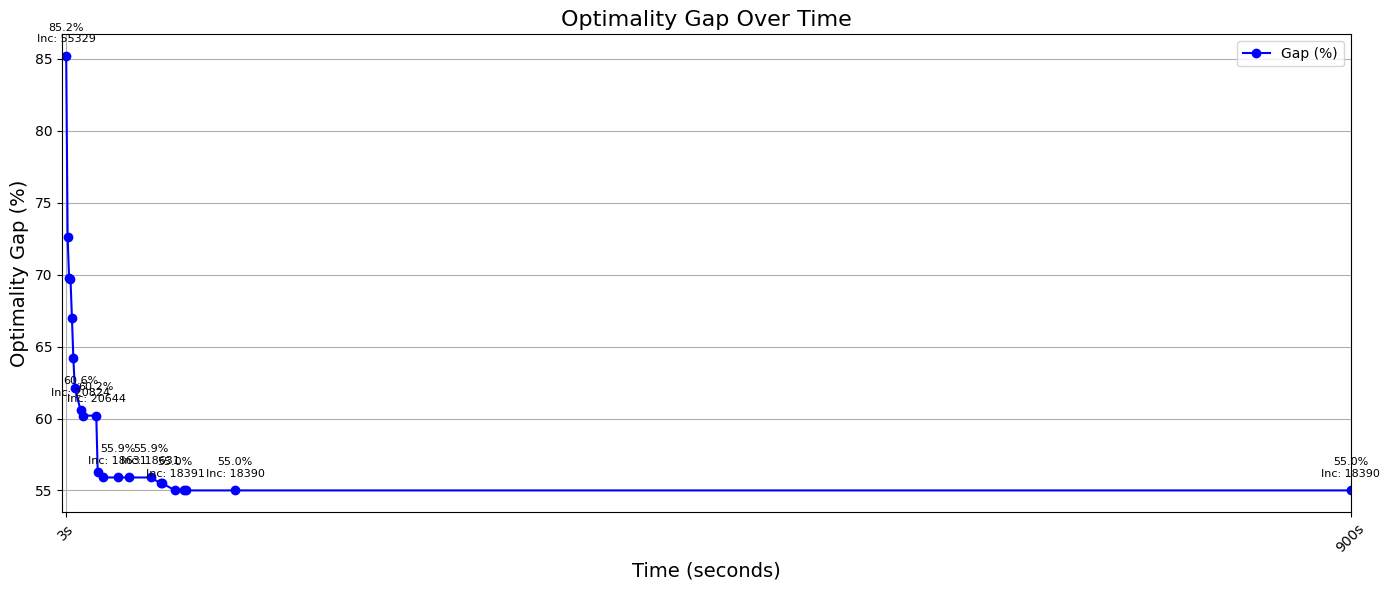

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Paste your log text as a multi-line string (shortened here for brevity)
log_lines = """
     0     0 8209.80998    0   86          - 8209.80998      -     -    2s
H    0     0                    73053.012611 8209.80998  88.8%     -    3s
H    0     0                    62368.539720 8209.80998  86.8%     -    3s
H    0     0                    60999.444643 8209.80998  86.5%     -    3s
     0     0 8209.80998    0   88 60999.4446 8209.80998  86.5%     -    3s
H    0     0                    55329.444643 8209.80998  85.2%     -    3s
H    0     0                    49375.376066 8209.80998  83.4%     -    4s
     0     0 8209.80998    0   82 49375.3761 8209.80998  83.4%     -    4s
H    0     0                    33445.933851 8209.80998  75.5%     -    4s
H    0     0                    30010.390384 8209.80998  72.6%     -    4s
     0     0 8209.80998    0   79 30010.3904 8209.80998  72.6%     -    4s
H    0     0                    29351.252235 8209.80998  72.0%     -    5s
     0     0 8209.80998    0   91 29351.2522 8209.80998  72.0%     -    5s
H    0     0                    27147.399506 8209.80998  69.8%     -    5s
     0     0 8209.80998    0   82 27147.3995 8209.80998  69.8%     -    5s
     0     0 8209.80998    0   82 27147.3995 8209.80998  69.8%     -    6s
     0     0 8209.80998    0   82 27147.3995 8209.80998  69.8%     -    6s
H    0     0                    27072.400475 8209.80998  69.7%     -    6s
     0     0 8209.80998    0   82 27072.4005 8209.80998  69.7%     -    6s
     0     0 8209.80998    0   82 27072.4005 8209.80998  69.7%     -    7s
H    0     0                    24872.431386 8209.80998  67.0%     -    7s
H    0     0                    22903.594585 8209.80998  64.2%     -    8s
     0     0 8209.80998    0   82 22903.5946 8209.80998  64.2%     -    8s
     0     0 8209.80998    0   82 22903.5946 8209.80998  64.2%     -    8s
H    0     0                    21660.343957 8209.81222  62.1%     -    9s
     0     2 8209.81222    0   82 21660.3440 8209.81222  62.1%     -   10s
H   27    31                    20824.708532 8209.81222  60.6%  58.1   13s
H   58    60                    20652.124150 8209.81313  60.2%  53.1   15s
   156   138 8210.05711   34   89 20652.1241 8209.81313  60.2%  32.3   23s
H  157   138                    20644.508532 8209.81313  60.2%  32.1   24s
   190   170 8210.12148   42   86 20644.5085 8209.81313  60.2%  30.8   25s
H  212   183                    18779.282922 8209.81313  56.3%  28.9   25s
H  301   269                    18632.244652 8209.81313  55.9%  27.4   29s
   306   282 8561.61593   66   69 18632.2447 8209.81313  55.9%  27.1   30s
   485   384 18253.8811   99   69 18632.2447 8209.81313  55.9%  30.5   35s
H  594   427                    18631.388374 8209.81313  55.9%  30.6   39s
   605   448 infeasible  126      18631.3884 8209.81793  55.9%  30.5   40s
H  757   567                    18631.388371 8209.81793  55.9%  32.5   47s
   864   715 8390.32737   31   85 18631.3884 8209.94657  55.9%  32.7   51s
  1055   845 11638.3727   56   80 18631.3884 8209.94657  55.9%  31.6   55s
  1187   916 13437.6433   76   82 18631.3884 8209.94657  55.9%  32.9   60s
H 1189   871                    18631.388369 8209.94657  55.9%  32.9   62s
  1191   873 15141.8862   53   82 18631.3884 8209.94657  55.9%  32.8   65s
H 1221   852                    18631.388364 8282.55983  55.5%  37.6   69s
  1223   855 8282.56294   17   68 18631.3884 8282.55983  55.5%  37.6   70s
H 1224   813                    18614.175507 8282.55983  55.5%  37.6   70s
  1306   869 8554.20392   26   72 18614.1755 8282.55983  55.5%  40.9   75s
H 1320   834                    18391.850601 8282.55983  55.0%  41.3   79s
  1344   855 13653.5806   31   69 18391.8506 8282.55983  55.0%  42.5   80s
  1446   908 8554.40329   43   67 18391.8506 8282.55983  55.0%  49.2   85s
H 1448   869                    18390.996693 8282.55983  55.0%  49.5   85s
H 1452   837                    18390.996688 8282.55983  55.0%  50.0   87s
H 1454   802                    18390.996686 8282.55983  55.0%  50.0   87s
  1498   845 8829.16677   50   71 18390.9967 8282.55983  55.0%  52.6   90s
  1610   897 8382.44896   19   54 18390.9967 8282.57280  55.0%  59.9   95s
  1701   922 8860.82026   29   52 18390.9967 8282.57280  55.0%  60.3  103s
  1705   932 8863.56499   29   57 18390.9967 8282.57280  55.0%  60.4  105s
  1810  1029 11680.7964   44   43 18390.9967 8282.57280  55.0%  62.0  110s
  1947  1105 11675.1255   61   42 18390.9967 8282.57280  55.0%  65.5  116s
  2113  1200 14641.3279   82   41 18390.9967 8282.57280  55.0%  67.7  120s
H 2236  1175                    18390.996683 8282.57280  55.0%  67.9  121s
  2314  1213     cutoff  104      18390.9967 8282.57280  55.0%  68.2  125s
  2438  1224 13801.2930  114   32 18390.9967 8282.57280  55.0%  68.3  134s
  2442  1283     cutoff  114      18390.9967 8282.57280  55.0%  68.3  137s
  2532  1311 8487.27015   24   63 18390.9967 8317.26256  54.8%  68.4  141s
  2697  1462 11784.2226   44   38 18390.9967 8317.26256  54.8%  69.4  147s
  2849  1471 17918.7364   75   21 18390.9967 8317.26256  54.8%  67.9  151s
  2928  1517 11320.4064   34   38 18390.9967 8320.34307  54.8%  68.9  157s
  3023  1607 infeasible   59      18390.9967 8344.95998  54.6%  69.4  161s
  3249  1697 11405.9515   90   59 18390.9967 8349.88327  54.6%  68.7  165s
  3409  1906 12563.3010   74   63 18390.9967 8349.89102  54.6%  67.5  173s
  3561  2036 11918.7169   42   38 18390.9967 8371.94083  54.5%  66.7  177s
  3722  2169 10413.9578   42   53 18390.9967 8372.66489  54.5%  66.4  181s
  3893  2264 8762.64109   44   72 18390.9967 8372.66694  54.5%  65.9  188s
  4099  2409 17580.0036   60   72 18390.9967 8381.58226  54.4%  64.7  193s
  4282  2580 11710.2758   62   80 18390.9967 8381.58226  54.4%  64.4  197s
  4474  2706 16355.8049  111   65 18390.9967 8382.39436  54.4%  63.4  202s
  4659  2865 13023.0995   43   59 18390.9967 8382.39436  54.4%  63.6  206s
  4853  3070 11050.6212   24   60 18390.9967 8382.40930  54.4%  63.6  215s
  5136  3284 9295.02466   30   86 18390.9967 8392.25775  54.4%  62.5  221s
  5379  3503 12015.0914   86   93 18390.9967 8392.25775  54.4%  62.8  226s
  5658  3764 infeasible  125      18390.9967 8405.28448  54.3%  62.5  230s
  6046  3983 9113.62101   47   46 18390.9967 8406.65113  54.3%  62.0  235s
  6737  4391 17247.8734   54   23 18390.9967 8410.16029  54.3%  62.0  244s
  6988  4639 9535.07696   62   83 18390.9967 8414.20492  54.2%  61.5  249s
  7324  4969 16436.1524   58   45 18390.9967 8415.01889  54.2%  61.8  253s
  7738  5270 17840.2389   53   72 18390.9967 8415.02004  54.2%  61.8  259s
  8121  5528 14004.5953   73   47 18390.9967 8422.60264  54.2%  62.3  264s
  8449  5757 18115.2246  113   38 18390.9967 8422.60264  54.2%  62.7  270s
  8783  6001 15798.4739   40   69 18390.9967 8424.83238  54.2%  62.7  277s
  9150  6269 17959.7166   87   55 18390.9967 8424.85028  54.2%  62.2  282s
  9520  6525 12579.3007   77   71 18390.9967 8427.28334  54.2%  63.4  289s
  9903  6968 12684.2043   54   69 18390.9967 8434.58539  54.1%  63.6  295s
 10417  7180 8876.94692   31   67 18390.9967 8439.21054  54.1%  62.5  306s
 10685  7804 12181.2069   39   68 18390.9967 8439.21054  54.1%  62.5  317s
 11502  8235 15812.1203   96   72 18390.9967 8439.21054  54.1%  61.9  324s
 12101  8533 8449.29602   26   63 18390.9967 8449.22776  54.1%  61.6  331s
 12543  8822 16052.2154   44   47 18390.9967 8449.77410  54.1%  61.3  338s
 12987  9221 11035.9804   28   62 18390.9967 8451.28726  54.0%  61.5  344s
 13590  9568 17810.8882   52   44 18390.9967 8455.61326  54.0%  60.8  349s
 14002  9880 16366.0575   79   77 18390.9967 8460.71314  54.0%  61.2  354s
 14461 10255 11882.1100   36   62 18390.9967 8464.55016  54.0%  61.4  360s
 14938 10691 15269.6973   61   44 18390.9967 8464.72004  54.0%  61.2  366s
 15519 10699 11562.6273   46   75 18390.9967 8470.98557  53.9%  60.5  376s
 15533 10886 11562.6290   48   60 18390.9967 8471.77789  53.9%  60.5  382s
 15765 11278 11322.0492   27   75 18390.9967 8471.78688  53.9%  60.4  388s
 16278 11509 14006.4411   63   86 18390.9967 8472.57250  53.9%  60.2  394s
 16631 11773 15999.6810  102   44 18390.9967 8476.82604  53.9%  60.0  402s
 17031 11950 17047.0299   62   76 18390.9967 8480.10998  53.9%  59.7  408s
 17342 12368 17864.3531   86   43 18390.9967 8481.46534  53.9%  59.3  413s
 17897 12554 14764.8238   43   34 18390.9967 8481.59455  53.9%  58.8  419s
 18154 12840 12601.7698   68   93 18390.9967 8485.85289  53.9%  58.7  426s
 18568 13139 12806.5200   47   61 18390.9967 8487.27418  53.9%  58.4  437s
 19000 13547 11911.8060   37   42 18390.9967 8487.76372  53.8%  58.5  444s
 19489 13979 16474.1207  160   87 18390.9967 8489.65401  53.8%  58.3  451s
 20011 14280 17514.7866   86   31 18390.9967 8489.85362  53.8%  58.3  457s
 20480 14414 14823.9836   42   79 18390.9967 8489.88220  53.8%  58.2  465s
 20655 15024     cutoff   39      18390.9967 8489.88220  53.8%  58.4  571s
 21425 15224 infeasible  165      18390.9967 8489.88220  53.8%  57.7  575s
 22125 15690 11591.6251   34   45 18390.9967 8495.38346  53.8%  57.5  584s
 22436 15821 infeasible   53      18390.9967 8495.38735  53.8%  57.4  588s
 22626 16135 13508.8258   49   26 18390.9967 8495.40515  53.8%  57.3  593s
 23030 16576 14822.2315   42   29 18390.9967 8495.43102  53.8%  56.9  598s
 23595 16594 infeasible  114      18390.9967 8497.99671  53.8%  56.3  609s
 23623 16796 18034.1257  113   74 18390.9967 8499.66937  53.8%  56.2  614s
 23956 16870 11568.3336   51   70 18390.9967 8499.66937  53.8%  56.1  622s
 24035 17107 12373.3367   85   65 18390.9967 8499.66937  53.8%  56.0  629s
 24305 17512 16281.8903  138   72 18390.9967 8499.68116  53.8%  55.9  635s
 24845 17651 10574.2173   40   58 18390.9967 8505.16756  53.8%  55.7  642s
 25081 17962 8562.61272   24   87 18390.9967 8506.18263  53.7%  55.7  652s
 25476 18283 infeasible   60      18390.9967 8506.53445  53.7%  55.8  660s
 25938 18469 9317.35575   48   55 18390.9967 8506.57938  53.7%  56.0  667s
 26176 18766 18196.9537   91   24 18390.9967 8507.97336  53.7%  56.0  677s
 26641 18977 infeasible   94      18390.9967 8510.72834  53.7%  56.0  685s
 26936 19138 15234.0217   81   55 18390.9967 8512.73097  53.7%  56.1  694s
 27195 19371 9910.63227   34   62 18390.9967 8513.53622  53.7%  56.2  705s
 27598 19578 11706.8295   37   56 18390.9967 8514.10062  53.7%  56.3  715s
 27873 19708 14774.9635   44   64 18390.9967 8515.25462  53.7%  56.3  730s
 28022 20019 16072.4427   51   57 18390.9967 8515.55288  53.7%  56.3  743s
 28487 20104 12101.6881   42   58 18390.9967 8517.54165  53.7%  56.2  767s
 28607 20349 8708.37201   30   81 18390.9967 8517.55141  53.7%  56.2  777s
 28933 20552 8527.08302   34   89 18390.9967 8517.61644  53.7%  56.4  790s
 29215 20817 12604.7240   73   89 18390.9967 8518.15446  53.7%  56.5  804s
 29589 21053 14989.7391   56   47 18390.9967 8518.36151  53.7%  56.5  814s
 29893 21441 11073.8405   44   74 18390.9967 8518.69061  53.7%  56.4  825s
 30389 21692 infeasible   60      18390.9967 8520.55015  53.7%  56.3  835s
 30820 21851 8589.61342   37   93 18390.9967 8521.13652  53.7%  56.2  847s
 30985 22393 10265.4008  103   99 18390.9967 8521.79292  53.7%  56.4  866s
 31680 22622 10138.1211  110  103 18390.9967 8521.97607  53.7%  56.3  877s
 31964 22742 14353.4582  190   74 18390.9967 8521.99892  53.7%  56.2  889s
 32128 23115 17346.3427   48   26 18390.9967 8521.99892  53.7%  56.2  900s
""".strip().splitlines()

data = []

for line in log_lines:
    if line.strip().startswith('H'):
        parts = line.split()
        try:
            incumbent = float(parts[3])
            best_bound = float(parts[4])
            gap_str = parts[5].strip('%')
            gap = float(gap_str)
            time_str = parts[-1]
            time = int(time_str.strip('s'))
            data.append((time, gap, incumbent))
        except (IndexError, ValueError):
            continue

# Remove duplicates by time and sort
data_dict = {t: (g, inc) for t, g, inc in data}
data = sorted(data_dict.items())

# Extract times, gaps, incumbents
times = [t for t, _ in data]
gaps = [v[0] for _, v in data]
incumbents = [v[1] for _, v in data]

# Extend to 900s using last known values
if times and times[-1] < 900:
    times.append(900)
    gaps.append(gaps[-1])
    incumbents.append(incumbents[-1])

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(times, gaps, marker='o', color='blue', label='Gap (%)')

# Annotate only significant changes
# Annotate only significant changes with reduced clutter in early times
prev_gap = None
prev_inc = None
prev_time = -999

for t, g, inc in zip(times, gaps, incumbents):
    min_time_gap = 10  # only annotate points at least 10s apart
    gap_changed = prev_gap is None or abs(g - prev_gap) > 0.5
    inc_changed = prev_inc is None or inc != prev_inc
    far_enough = (t - prev_time) >= min_time_gap
    is_final = t == 900

    if (gap_changed or inc_changed) and far_enough or is_final:
        ax.annotate(f"{g:.1f}%\nInc: {int(inc)}", xy=(t, g), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=8)
        prev_gap = g
        prev_inc = inc
        prev_time = t


# X-axis ticks: fixed spacing (start, some middle points, end)
xticks = sorted(set([times[0], *[t for t in times if t % 100 == 0], 900]))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t}s" if t in xticks else "..." for t in xticks], rotation=45)

# Labels and layout
ax.set_xlim(0, 900)
ax.set_title("Optimality Gap Over Time", fontsize=16)
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Optimality Gap (%)", fontsize=14)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

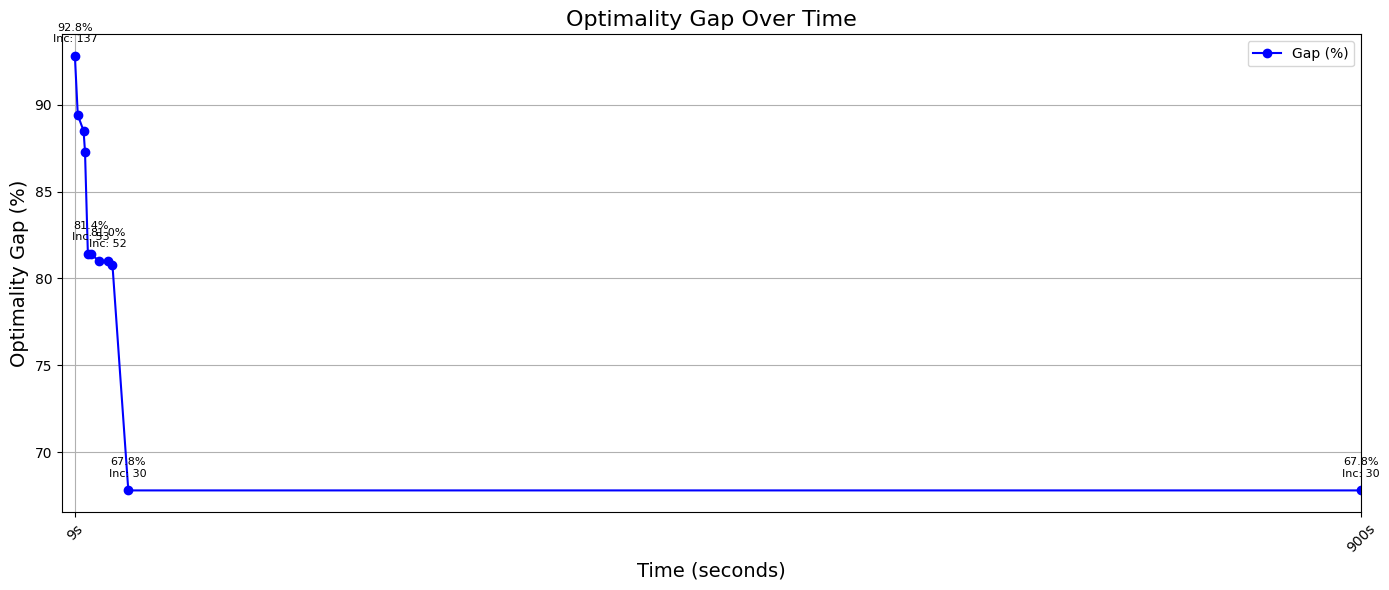

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Paste your log text as a multi-line string (shortened here for brevity)
log_lines = """
     0     0    9.89969    0   82          -    9.89969      -     -    7s
H    0     0                     156.3264158    9.89969  93.7%     -    9s
H    0     0                     137.4175191    9.89969  92.8%     -    9s
     0     0    9.89969    0   82  137.41752    9.89969  92.8%     -   10s
     0     0    9.89969    0   82  137.41752    9.89969  92.8%     -   11s
H    0     0                      93.0816591    9.89969  89.4%     -   11s
     0     0    9.89969    0   82   93.08166    9.89969  89.4%     -   12s
H    0     0                      86.0707824    9.89969  88.5%     -   15s
     0     0    9.89969    0   82   86.07078    9.89969  88.5%     -   15s
H    0     0                      77.8048599    9.89969  87.3%     -   16s
     0     0    9.89969    0   87   77.80486    9.89969  87.3%     -   16s
     0     0    9.89969    0   87   77.80486    9.89969  87.3%     -   18s
H    0     0                      53.2345782    9.89969  81.4%     -   18s
     0     0    9.89969    0   87   53.23458    9.89969  81.4%     -   18s
     0     0    9.89969    0   87   53.23458    9.89969  81.4%     -   19s
H    0     0                      53.2345765    9.89969  81.4%     -   20s
     0     0    9.89970    0   87   53.23458    9.89970  81.4%     -   20s
     0     0    9.89970    0   86   53.23458    9.89970  81.4%     -   20s
     0     0    9.89970    0   86   53.23458    9.89970  81.4%     -   21s
     0     2    9.93820    0   86   53.23458    9.93820  81.3%     -   23s
    15    19    9.93820    5   88   53.23458    9.93820  81.3%  69.6   25s
H   30    30                      52.3960600    9.93820  81.0%  49.7   26s
H   59    61                      52.2645672    9.93820  81.0%  49.9   32s
    93    85   10.91781   20   66   52.26457    9.93820  81.0%  41.7   35s
H   94    85                      51.6678602    9.93820  80.8%  41.3   35s
   151   115   11.68435   30   56   51.66786    9.93820  80.8%  30.7   42s
   201   141   11.68450   42   75   51.66786    9.93820  80.8%  24.9   46s
H  203   141                      30.8392203    9.93820  67.8%  24.7   46s
   295   213   11.68475   71   63   30.83922    9.93820  67.8%  23.3   50s
   363   252 infeasible   96        30.83922    9.93820  67.8%  22.0   56s
   430   307   10.06147   19   77   30.83922    9.97672  67.6%  23.4   61s
   450   312   10.06151   25   90   30.83922    9.97672  67.6%  24.0   65s
   539   420   10.60083   48   67   30.83922    9.97672  67.6%  26.2   71s
   672   510   18.24871   90   74   30.83922    9.97672  67.6%  25.4   89s
   676   514   18.24871   91   76   30.83922    9.97672  67.6%  25.3   91s
   917   730 infeasible  141        30.83922    9.97672  67.6%  24.8   95s
  1014   813   10.90863   18   69   30.83922   10.06117  67.4%  26.9  100s
  1235   926   10.44430   23   86   30.83922   10.06117  67.4%  26.4  106s
  1239   929   10.77610   17   82   30.83922   10.06117  67.4%  26.3  111s
  1267   952   10.06119   19   83   30.83922   10.06119  67.4%  29.2  115s
  1331   995   10.31844   26   78   30.83922   10.06119  67.4%  30.7  120s
  1396  1036   10.23838   35   78   30.83922   10.06119  67.4%  32.4  127s
  1412  1047   10.23838   37   78   30.83922   10.06119  67.4%  32.6  130s
  1563  1168   11.26431   58   64   30.83922   10.06119  67.4%  35.2  135s
  1794  1294   17.96158   80   68   30.83922   10.06119  67.4%  39.3  140s
  1969  1390   11.27978   96   79   30.83922   10.06119  67.4%  41.8  147s
  1997  1384   11.27983  100   77   30.83922   10.06119  67.4%  42.5  157s
  2013  1430   11.27983  101   76   30.83922   10.06119  67.4%  43.0  160s
  2269  1546   11.28035  135   73   30.83922   10.06119  67.4%  47.1  165s
  2290  1599   17.18977  136   48   30.83922   10.06119  67.4%  47.0  170s
  2587  1772   11.31186   39   82   30.83922   10.06119  67.4%  48.4  175s
  2848  1896   24.56663   69   65   30.83922   10.06119  67.4%  49.3  180s
  3017  1995   19.78754   90   64   30.83922   10.06119  67.4%  50.8  186s
  3195  2091   28.42561  113   66   30.83922   10.06119  67.4%  51.0  190s
  3586  2242   19.55518   57   45   30.83922   10.06119  67.4%  51.0  196s
  3831  2358   19.55546  113   39   30.83922   10.06119  67.4%  49.5  202s
  3875  2347   19.55546  115   32   30.83922   10.06119  67.4%  49.7  215s
  4273  2737   10.74550   29   81   30.83922   10.06119  67.4%  48.5  221s
  4695  3101   30.79755   75   62   30.83922   10.06121  67.4%  48.7  227s
  4951  3191 infeasible   43        30.83922   10.21055  66.9%  48.2  231s
  5273  3516   20.58271   76   63   30.83922   10.21055  66.9%  48.3  236s
  5498  3689   10.22277   28   85   30.83922   10.21055  66.9%  47.5  240s
  5921  4042   25.84528   94   38   30.83922   10.21055  66.9%  46.9  247s
  6092  4195   25.84531  136   28   30.83922   10.21055  66.9%  47.1  251s
  6296  4332   25.84563  184   36   30.83922   10.22266  66.9%  47.0  256s
  6465  4472   10.59011   58   56   30.83922   10.22349  66.8%  47.0  261s
  6695  4707 infeasible   48        30.83922   10.23839  66.8%  47.3  265s
  7012  4974   21.21600  109   34   30.83922   10.25954  66.7%  47.1  270s
  7389  5246   24.65348   66   56   30.83922   10.28292  66.7%  46.9  275s
  7752  5529   10.76334   43   94   30.83922   10.28292  66.7%  46.8  281s
  8096  5803   18.23293   69   79   30.83922   10.28292  66.7%  46.4  286s
  8506  6077   18.23319   87   82   30.83922   10.28292  66.7%  46.6  291s
  8909  6365   26.08213  110   78   30.83922   10.28292  66.7%  46.5  298s
  9289  6664   18.23389  131   91   30.83922   10.28292  66.7%  46.5  304s
  9668  7103     cutoff  158        30.83922   10.28295  66.7%  46.3  310s
 10195  7610   14.45820   56   60   30.83922   10.28729  66.6%  45.3  316s
 10873  8198   12.40693   54   90   30.83922   10.29978  66.6%  44.5  327s
 11611  8465   27.79250  109   30   30.83922   10.33961  66.5%  43.8  331s
 11961  8834   20.91861   45   46   30.83922   10.35413  66.4%  44.0  336s
 12470  9142   19.91723   46   61   30.83922   10.35533  66.4%  43.4  340s
 12870  9448   19.91745  129   72   30.83922   10.35534  66.4%  43.2  345s
 13284  9449   30.25605   79   28   30.83922   10.35537  66.4%  43.1  357s
 13298  9775   30.73151   80   25   30.83922   10.35538  66.4%  43.1  362s
 13743  9852   19.89464   52   36   30.83922   10.36298  66.4%  42.7  368s
H13771  9846                      30.7139003   10.36298  66.3%  42.6  369s
 13859 10096   10.87760   28   69   30.71390   10.36298  66.3%  42.6  374s
 14206 10408   10.76302   25   76   30.71390   10.36298  66.3%  42.5  379s
 14630 10682   20.50244   54   73   30.71390   10.36298  66.3%  42.2  385s
 14977 10959   18.55461   92   59   30.71390   10.36299  66.3%  42.0  390s
 15383 11331   27.81781  101   71   30.71390   10.36300  66.3%  41.5  395s
 15893 11701   18.81201   49   47   30.71390   10.36301  66.3%  41.5  400s
 16398 12111   12.02846   86   71   30.71390   10.36302  66.3%  41.3  405s
 16904 12504   20.28689  102   74   30.71390   10.36302  66.3%  41.2  410s
 17715 12911 infeasible   93        30.71390   10.36317  66.3%  41.3  419s
 18154 13235 infeasible   65        30.71390   10.36322  66.3%  41.5  424s
 18608 13447   19.41588  104   87   30.71390   10.37865  66.2%  41.5  434s
H18686 13421                      30.4283445   10.37865  65.9%  41.6  434s
 18924 13683 infeasible   71        30.42834   10.38414  65.9%  41.7  440s
 19704 14232   18.32828   41   79   30.42834   10.38416  65.9%  41.6  455s
H19794 14232                      30.4283402   10.38416  65.9%  41.5  455s
 19978 14661   11.82277   74   94   30.42834   10.38416  65.9%  41.5  461s
 20524 15027   27.86854  200   54   30.42834   10.38418  65.9%  41.1  466s
 21054 15373   17.96982   87   69   30.42834   10.38454  65.9%  40.9  470s
 21519 15891   18.83653   99   71   30.42834   10.38890  65.9%  41.0  559s
 22174 16098   26.22725   79   70   30.42834   10.39807  65.8%  40.8  564s
 22457 16439   25.96122   72   32   30.42834   10.39922  65.8%  40.7  569s
 22908 16769   11.55650   37   74   30.42834   10.40521  65.8%  40.3  574s
 23341 17019   27.03885   48   64   30.42834   10.40527  65.8%  40.5  578s
 23727 17094   14.47438   53   67   30.42834   10.41211  65.8%  40.7  584s
 23892 17417   17.61734   52   50   30.42834   10.41666  65.8%  40.7  588s
 24332 17698   16.92080   37   38   30.42834   10.43115  65.7%  40.7  593s
 24774 17976   24.31021   62   40   30.42834   10.43541  65.7%  40.8  597s
 25158 18326   17.15027   66   88   30.42834   10.43542  65.7%  40.7  602s
 25602 18668   22.19327   72   57   30.42834   10.43544  65.7%  40.9  605s
 26455 19224   10.95615   39   76   30.42834   10.44002  65.7%  41.0  617s
 26817 19349   10.46123   33   48   30.42834   10.44004  65.7%  40.9  622s
 26980 19739   17.71361   46   83   30.42834   10.44220  65.7%  40.9  625s
 28007 20346   27.00329   43   71   30.42834   10.44852  65.7%  41.1  633s
 28422 20661   27.44454   56   51   30.42834   10.45660  65.6%  41.2  638s
 28888 20946 infeasible   74        30.42834   10.45662  65.6%  41.3  643s
 29278 21212   13.78016   54   85   30.42834   10.45666  65.6%  41.3  647s
 29702 21485   27.31962   64   56   30.42834   10.45668  65.6%  41.5  651s
 30108 21743   28.95469   65   48   30.42834   10.46118  65.6%  41.5  656s
 30460 22127   10.82269   39   63   30.42834   10.46119  65.6%  41.4  661s
 30934 22303   22.32127   70   26   30.42834   10.46119  65.6%  41.3  666s
H31091 22303                      30.4283391   10.46119  65.6%  41.3  666s
 31210 22697   23.42086   63   54   30.42834   10.46119  65.6%  41.3  671s
 31696 22962   24.41419   44   65   30.42834   10.46120  65.6%  41.2  678s
H31766 22962                      30.4283391   10.46120  65.6%  41.2  678s
H31840 22962                      30.4283390   10.46120  65.6%  41.2  678s
 32023 23447   11.39661   46   73   30.42834   10.46120  65.6%  41.2  686s
 33242 23956   29.90045  163   89   30.42834   10.46120  65.6%  40.7  693s
 33272 24186   11.11954   31   61   30.42834   10.46120  65.6%  40.7  697s
 33583 24359   12.18254   38   50   30.42834   10.46120  65.6%  40.8  701s
 33779 24606   27.69490   78    8   30.42834   10.46120  65.6%  40.9  706s
 34178 24922   19.63538   35   57   30.42834   10.46121  65.6%  40.9  710s
 34582 25402   19.82880   56   80   30.42834   10.46121  65.6%  40.9  715s
H35584 25881                      30.4283390   10.46122  65.6%  40.6  724s
 35834 26132   26.81849   83   85   30.42834   10.46122  65.6%  40.6  729s
 36176 26540   27.26872   84   45   30.42834   10.46123  65.6%  40.6  733s
 36717 26616   11.25523   37   74   30.42834   10.46123  65.6%  40.5  738s
 36801 26969   12.76190   46   51   30.42834   10.46123  65.6%  40.6  744s
 37278 27216   18.47817   57   70   30.42834   10.46124  65.6%  40.4  755s
 37622 27468   20.33011   48   45   30.42834   10.46125  65.6%  40.4  760s
H38014 27490                      30.4283390   10.46125  65.6%  40.4  769s
 38047 27839   11.13778   45   75   30.42834   10.46126  65.6%  40.5  775s
 38587 28146   10.89333   38   50   30.42834   10.46128  65.6%  40.4  780s
 38961 28555   21.76490   77   31   30.42834   10.46128  65.6%  40.5  786s
 39470 28658     cutoff  113        30.42834   10.46138  65.6%  40.4  792s
 39629 29004   20.33649   69   54   30.42834   10.46334  65.6%  40.4  797s
 40171 29269   10.76314   28   81   30.42834   10.47539  65.6%  40.3  803s
 40568 29517   12.59488   47   94   30.42834   10.47783  65.6%  40.3  809s
 40849 29818   14.51565  129   76   30.42834   10.47786  65.6%  40.3  815s
 41299 30090   23.88397   54   60   30.42834   10.47992  65.6%  40.3  821s
 41702 30419   12.40554   46   55   30.42834   10.47997  65.6%  40.3  826s
 42162 30683   29.20464   65   37   30.42834   10.47997  65.6%  40.3  833s
 42553 31018 infeasible   60        30.42834   10.48134  65.6%  40.4  840s
 43022 31276   14.28294   91   74   30.42834   10.48238  65.6%  40.4  847s
H43077 31276                      30.4283390   10.48238  65.6%  40.4  847s
H43333 31276                      30.4283390   10.48238  65.6%  40.4  847s
 43343 31712   23.72318  143   59   30.42834   10.48298  65.5%  40.4  852s
 43951 32063   11.10210   31   70   30.42834   10.48598  65.5%  40.3  856s
 44429 32152   26.80497   65   30   30.42834   10.49058  65.5%  40.4  861s
 44611 32381   14.28330   75   81   30.42834   10.49509  65.5%  40.4  867s
 44890 32810   19.01675   52   57   30.42834   10.49738  65.5%  40.4  879s
 45403 33186   10.86394   40   59   30.42834   10.49964  65.5%  40.3  889s
 45841 33549   20.62554  128   48   30.42834   10.49969  65.5%  40.2  896s
 46309 33700 infeasible   52        30.42834   10.49972  65.5%  40.1  900s
""".strip().splitlines()

data = []

for line in log_lines:
    if line.strip().startswith('H'):
        parts = line.split()
        try:
            incumbent = float(parts[3])
            best_bound = float(parts[4])
            gap_str = parts[5].strip('%')
            gap = float(gap_str)
            time_str = parts[-1]
            time = int(time_str.strip('s'))
            data.append((time, gap, incumbent))
        except (IndexError, ValueError):
            continue

# Remove duplicates by time and sort
data_dict = {t: (g, inc) for t, g, inc in data}
data = sorted(data_dict.items())

# Extract times, gaps, incumbents
times = [t for t, _ in data]
gaps = [v[0] for _, v in data]
incumbents = [v[1] for _, v in data]

# Extend to 900s using last known values
if times and times[-1] < 900:
    times.append(900)
    gaps.append(gaps[-1])
    incumbents.append(incumbents[-1])

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(times, gaps, marker='o', color='blue', label='Gap (%)')

# Annotate only significant changes
# Annotate only significant changes with reduced clutter in early times
prev_gap = None
prev_inc = None
prev_time = -999

for t, g, inc in zip(times, gaps, incumbents):
    min_time_gap = 10  # only annotate points at least 10s apart
    gap_changed = prev_gap is None or abs(g - prev_gap) > 0.5
    inc_changed = prev_inc is None or inc != prev_inc
    far_enough = (t - prev_time) >= min_time_gap
    is_final = t == 900

    if (gap_changed or inc_changed) and far_enough or is_final:
        ax.annotate(f"{g:.1f}%\nInc: {int(inc)}", xy=(t, g), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=8)
        prev_gap = g
        prev_inc = inc
        prev_time = t


# X-axis ticks: fixed spacing (start, some middle points, end)
xticks = sorted(set([times[0], *[t for t in times if t % 100 == 0], 900]))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t}s" if t in xticks else "..." for t in xticks], rotation=45)

# Labels and layout
ax.set_xlim(0, 900)
ax.set_title("Optimality Gap Over Time", fontsize=16)
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Optimality Gap (%)", fontsize=14)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

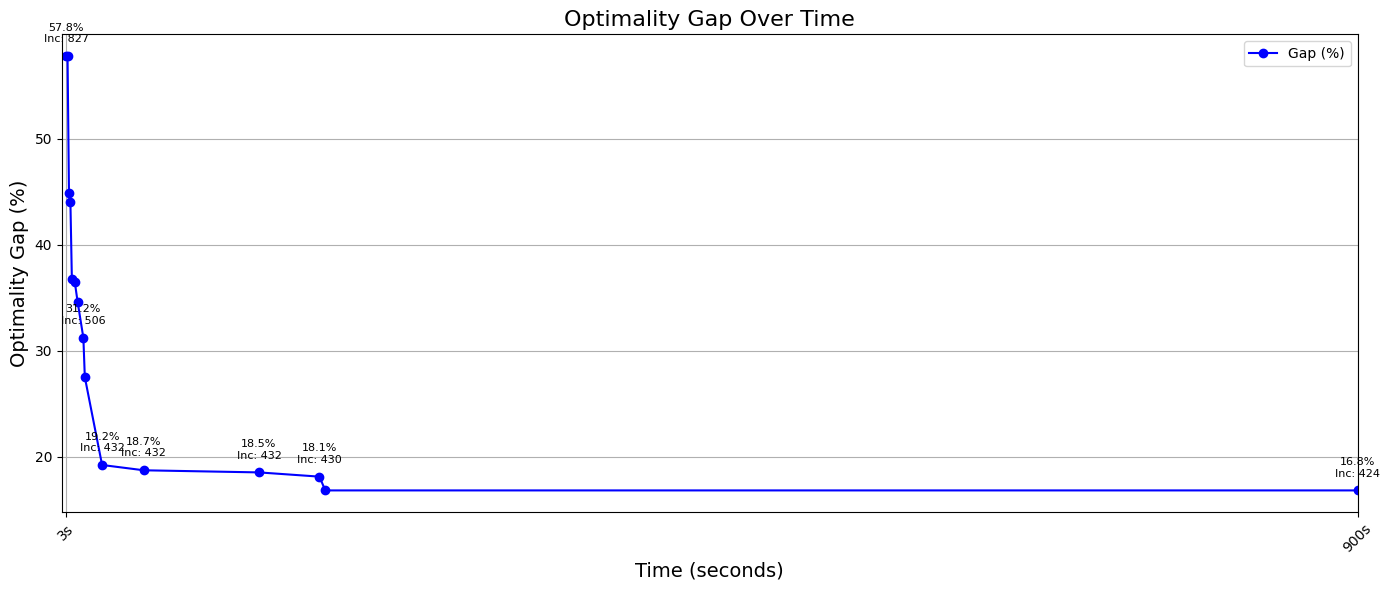

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Paste your log text as a multi-line string (shortened here for brevity)
log_lines = """
     0     0  348.99689    0   82          -  348.99689      -     -    2s
H    0     0                    1004.1675627  348.99689  65.2%     -    3s
H    0     0                     827.4415208  348.99689  57.8%     -    3s
     0     0  348.99689    0  111  827.44152  348.99689  57.8%     -    3s
H    0     0                     826.5931765  348.99689  57.8%     -    4s
     0     0  348.99689    0  111  826.59318  348.99689  57.8%     -    4s
     0     0  348.99689    0   82  826.59318  348.99689  57.8%     -    4s
H    0     0                     751.1669044  348.99689  53.5%     -    5s
H    0     0                     686.1554087  348.99689  49.1%     -    5s
     0     0  348.99689    0   82  686.15541  348.99689  49.1%     -    5s
     0     0  348.99689    0   82  686.15541  348.99689  49.1%     -    5s
H    0     0                     633.2514318  348.99689  44.9%     -    5s
H    0     0                     623.1864526  348.99689  44.0%     -    6s
     0     0  348.99689    0   82  623.18645  348.99689  44.0%     -    6s
     0     0  348.99689    0   82  623.18645  348.99689  44.0%     -    6s
     0     0  348.99689    0   82  623.18645  348.99689  44.0%     -    6s
     0     0  348.99689    0   82  623.18645  348.99689  44.0%     -    7s
H    0     0                     620.0551862  348.99689  43.7%     -    7s
H    0     0                     585.7928589  348.99689  40.4%     -    7s
     0     0  348.99689    0   82  585.79286  348.99689  40.4%     -    7s
H    0     0                     551.7928589  348.99689  36.8%     -    7s
     0     0  348.99689    0   82  551.79286  348.99689  36.8%     -    7s
     0     0  348.99689    0   82  551.79286  348.99689  36.8%     -    8s
H    0     0                     549.3651495  348.99693  36.5%     -    9s
     0     2  348.99693    0   82  549.36515  348.99693  36.5%     -    9s
     7    12  348.99693    3   87  549.36515  348.99693  36.5%   155   10s
H   27    28                     533.8390403  348.99693  34.6%  86.6   11s
H   60    55                     506.9732147  348.99693  31.2%  54.9   15s
H   96    88                     481.6619259  348.99693  27.5%  53.7   16s
   168   162  372.14151   39   63  481.66193  348.99693  27.5%  40.0   20s
H  207   186                     432.1626979  348.99693  19.2%  36.9   28s
H  208   186                     432.1626272  348.99693  19.2%  36.8   28s
   263   224  352.10625    5   70  432.16263  350.61173  18.9%  33.9   30s
   433   345  425.35058   25   65  432.16263  350.61173  18.9%  37.3   35s
   708   503  359.00224   36   88  432.16263  351.33583  18.7%  34.9   40s
   982   726  356.05810   17   76  432.16263  351.33597  18.7%  37.9   45s
  1232   862  378.78774   34   75  432.16263  351.33647  18.7%  39.2   50s
  1360   909  424.19751   39   82  432.16263  351.50581  18.7%  39.6   55s
H 1362   864                     432.1626271  351.50581  18.7%  39.6   57s
  1367   868  390.55831   62   82  432.16263  351.50581  18.7%  39.4   60s
  1449   926  358.70391   24   75  432.16263  351.59922  18.6%  43.4   65s
  1624  1023  403.38424   44   50  432.16263  351.59922  18.6%  45.7   70s
  1855  1139  352.01519   34   80  432.16263  351.59922  18.6%  48.7   75s
  1977  1208  352.01550   47   80  432.16263  351.59922  18.6%  49.7   80s
  2271  1327  384.29324   76   76  432.16263  351.59922  18.6%  50.5   85s
  2615  1510  356.02919   38   60  432.16263  352.01522  18.5%  50.9   91s
  3016  1658  359.28261   94   69  432.16263  352.01522  18.5%  48.1   95s
  3178  1704  359.28679  127   77  432.16263  352.01522  18.5%  48.0  100s
  3476  1752  386.67944   33   58  432.16263  352.04094  18.5%  47.5  105s
  3788  1944  370.63810   24   71  432.16263  352.10547  18.5%  46.5  110s
  4304  2209  367.50908   43   65  432.16263  352.10554  18.5%  45.0  116s
  4628  2452  375.19534   29   48  432.16263  352.22663  18.5%  45.0  121s
  5011  2793 infeasible   38       432.16263  352.22677  18.5%  45.0  125s
  5453  3070  363.32784   30   67  432.16263  352.22683  18.5%  44.3  131s
  6016  3413 infeasible   48       432.16263  352.22686  18.5%  44.0  137s
H 6112  3413                     432.1626270  352.22686  18.5%  43.9  137s
  6336  3556  358.99711   27   64  432.16263  352.50064  18.4%  43.9  141s
  6814  3939  373.10736   44   76  432.16263  352.99698  18.3%  43.6  148s
  7097  4104  384.32719   50   56  432.16263  352.99698  18.3%  43.8  152s
  7357  4298  384.02697   34   40  432.16263  352.99701  18.3%  43.7  156s
  8022  4774  365.80563   56   51  432.16263  352.99707  18.3%  43.8  163s
  8301  4898  399.80683   37   40  432.16263  352.99726  18.3%  44.5  167s
  8528  4924  422.99231   42   17  432.16263  352.99750  18.3%  44.5  174s
  8576  5081  422.99234   43   22  432.16263  352.99769  18.3%  44.5  179s
H 8712  5071                     430.8783917  352.99788  18.1%  44.6  179s
  8842  5194  366.08730   42   68  430.87839  352.99788  18.1%  44.7  183s
H 8856  5077                     424.1185076  352.99788  16.8%  44.7  183s
  9073  5356  358.31342   39   58  424.11851  352.99788  16.8%  44.8  187s
  9547  5646  353.00036   44   84  424.11851  353.00036  16.8%  44.8  192s
  9971  5883  395.63206   55   70  424.11851  353.03405  16.8%  45.4  197s
 10328  6268 infeasible   69       424.11851  353.03408  16.8%  45.2  204s
 10881  6521  407.15846   73   54  424.11851  353.03408  16.8%  45.8  207s
 11269  6782  396.58564   52   56  424.11851  353.03425  16.8%  45.9  211s
 11681  6991 infeasible   95       424.11851  353.03427  16.8%  45.9  217s
H12007  6946                     421.6622750  353.34979  16.2%  45.9  217s
 12095  7154     cutoff   53       421.66228  353.39630  16.2%  45.9  221s
 12478  7400  358.00051   35   48  421.66228  353.63124  16.1%  45.8  226s
 12922  7646  358.17636   44   40  421.66228  353.63131  16.1%  46.0  231s
 13394  7928 infeasible   68       421.66228  353.72128  16.1%  45.9  235s
 14263  8538  406.12142   63   88  421.66228  353.80440  16.1%  45.6  243s
 14738  8698  404.58026   70   54  421.66228  353.80440  16.1%  45.5  248s
 14987  9012  393.30726   84   67  421.66228  353.80440  16.1%  45.5  252s
 15446  9247  376.27113   91   86  421.66228  353.80444  16.1%  45.5  255s
 16111  9710  421.06851  111   50  421.66228  353.84160  16.1%  45.7  262s
 16591  9997  367.87135   46   53  421.66228  353.84172  16.1%  45.6  269s
 17102 10135  411.30544   49   60  421.66228  353.98646  16.0%  45.7  274s
 17339 10387  397.08666   69   52  421.66228  354.01288  16.0%  45.9  278s
 17868 10594  359.00505   45   76  421.66228  354.02626  16.0%  45.8  282s
 18195 10866  354.61188   31   47  421.66228  354.03407  16.0%  45.9  286s
 18694 11038  403.99447   63   82  421.66228  354.03427  16.0%  45.8  291s
 19062 11195  357.82793   24   78  421.66228  354.05205  16.0%  45.7  295s
 19288 11329  369.28775   26   62  421.66228  354.05205  16.0%  45.9  300s
 19925 11859 infeasible   53       421.66228  354.05209  16.0%  46.2  307s
 20303 12224  377.58076   47   52  421.66228  354.05211  16.0%  46.0  312s
 20902 12576  389.44084   38   52  421.66228  354.05234  16.0%  45.8  379s
 21427 12906     cutoff  105       421.66228  354.05243  16.0%  45.5  383s
 21950 13131  370.59015   39   59  421.66228  354.05271  16.0%  45.4  387s
 22335 13345  410.60696   78   36  421.66228  354.05271  16.0%  45.3  390s
 23230 13855  377.91655   32   54  421.66228  354.12901  16.0%  45.0  398s
 23467 14121     cutoff   58       421.66228  354.16636  16.0%  45.1  402s
 23900 14365  412.58758   84   69  421.66228  354.17460  16.0%  45.0  405s
 24297 14536  377.73793   52   72  421.66228  354.20372  16.0%  45.1  410s
 24564 14629  356.59643   49   81  421.66228  354.20376  16.0%  45.1  415s
H24584 14386                     417.5445474  354.20376  15.2%  45.1  415s
 24668 14388  364.89324   70   56  417.54455  354.20376  15.2%  45.2  421s
 24673 14648  369.72086   71   58  417.54455  354.20382  15.2%  45.2  425s
 25521 15267     cutoff   94       417.54455  354.23204  15.2%  45.1  433s
 25952 15481  371.20512   43   74  417.54455  354.23206  15.2%  45.3  437s
 26356 15804 infeasible   44       417.54455  354.23214  15.2%  45.4  442s
 26824 16082  396.59952   54   92  417.54455  354.23221  15.2%  45.3  446s
 27286 16401  393.00767   43   86  417.54455  354.23232  15.2%  45.2  450s
 27751 16579  375.91308   49   46  417.54455  354.23244  15.2%  45.2  455s
 28469 16881  398.89708   41   70  417.54455  354.35812  15.1%  45.4  463s
 28722 17233 infeasible   84       417.54455  354.39614  15.1%  45.3  466s
H29261 17181                     415.5356511  354.40060  14.7%  45.3  471s
 29428 17400  375.04533   65   50  415.53565  354.40509  14.7%  45.2  475s
 30131 17884 infeasible   83       415.53565  354.48125  14.7%  45.1  483s
 30578 18126 infeasible   53       415.53565  354.49875  14.7%  45.1  487s
 30960 18400  389.16248   75   58  415.53565  354.49893  14.7%  45.2  491s
 31436 18600  357.29374   40   74  415.53565  354.56561  14.7%  45.2  497s
 31789 19020     cutoff   59       415.53565  354.56568  14.7%  45.2  503s
 32542 19327  384.29384   81   63  415.53565  354.56581  14.7%  45.2  506s
 33066 19593  382.90163   57   53  415.53565  354.56597  14.7%  45.2  510s
 34053 20155 infeasible   40       415.53565  354.60096  14.7%  45.3  518s
H34054 19670                     411.1106090  354.60096  13.7%  45.3  518s
 34601 19970  363.75937   40   84  411.11061  354.61176  13.7%  45.2  522s
H35129 20283                     411.1106089  354.61179  13.7%  45.1  526s
 35588 20628  354.61244   27   47  411.11061  354.61182  13.7%  45.0  531s
 36145 20833     cutoff   53       411.11061  354.61187  13.7%  45.1  535s
 36546 21147  364.44307   53   67  411.11061  354.61189  13.7%  45.1  540s
 37376 21529  355.21480   34   85  411.11061  354.61192  13.7%  45.0  548s
 37777 21851  371.55352   66   68  411.11061  354.61193  13.7%  45.0  552s
 38232 22149  368.96626   27   46  411.11061  354.61194  13.7%  45.1  559s
 38692 22528  378.57898   42   44  411.11061  354.61201  13.7%  45.1  562s
 39237 22723 infeasible   68       411.11061  354.61209  13.7%  45.0  567s
H39238 22723                     411.1106087  354.61209  13.7%  45.0  567s
 39661 23007  379.45539   54   40  411.11061  354.61213  13.7%  45.0  571s
 40155 23224     cutoff   65       411.11061  354.61230  13.7%  45.0  575s
 41142 23716 infeasible   48       411.11061  354.62705  13.7%  45.1  582s
 41616 23882 infeasible   63       411.11061  354.63352  13.7%  45.0  586s
 42001 24191  400.23963   57   62  411.11061  354.71744  13.7%  45.1  591s
 43033 24860 infeasible   68       411.11061  354.79644  13.7%  45.0  597s
 43510 25093  393.60740   65   80  411.11061  354.80440  13.7%  45.0  602s
 43914 25324 infeasible   48       411.11061  354.80444  13.7%  45.0  606s
 44306 25489  382.88290   40   38  411.11061  354.80984  13.7%  45.1  610s
 44613 25630  398.57994   49   49  411.11061  354.80993  13.7%  45.0  615s
 45221 25966 infeasible   54       411.11061  354.81005  13.7%  45.0  623s
 45477 26189     cutoff   54       411.11061  354.81025  13.7%  45.1  627s
 45946 26477  369.66980   51   53  411.11061  354.83370  13.7%  45.1  631s
 46437 26723  394.36112   32   54  411.11061  354.84962  13.7%  45.1  636s
 47098 27102  373.77101   64   47  411.11061  354.85955  13.7%  45.2  645s
 47860 27618  369.59672   48   47  411.11061  354.97387  13.7%  45.3  653s
 48384 27802 infeasible   46       411.11061  354.97391  13.7%  45.4  657s
 48730 28147  374.44377   57   53  411.11061  355.01816  13.6%  45.4  660s
 49329 28303  373.36550   59  133  411.11061  355.03944  13.6%  45.4  665s
 50127 28784     cutoff   73       411.11061  355.03950  13.6%  45.4  673s
 50465 29146  360.77634   70   64  411.11061  355.03950  13.6%  45.4  676s
 50986 29558  357.03442   45   88  411.11061  355.03955  13.6%  45.4  681s
 51561 29906  390.45919   86   73  411.11061  355.03958  13.6%  45.4  687s
 52122 30122  367.46727   52   67  411.11061  355.03970  13.6%  45.3  690s
 52480 30468  362.06381   50   85  411.11061  355.03977  13.6%  45.3  695s
 53005 30706  375.04016   49   74  411.11061  355.03984  13.6%  45.4  700s
 53825 31277  374.85958   60   76  411.11061  355.04003  13.6%  45.4  707s
 54245 31613  370.86304   39   49  411.11061  355.09477  13.6%  45.4  710s
 55099 32043  355.48325   32   93  411.11061  355.21411  13.6%  45.4  718s
 55570 32268  358.31153   21   74  411.11061  355.21414  13.6%  45.4  722s
 55910 32485  355.33644   41   58  411.11061  355.21471  13.6%  45.4  727s
 56310 32676  379.83363   61   59  411.11061  355.21506  13.6%  45.4  731s
 56611 32829  384.81401   82   89  411.11061  355.22160  13.6%  45.4  735s
 57510 33222  380.16685   50   59  411.11061  355.24715  13.6%  45.4  743s
 57915 33507  409.92846   40   40  411.11061  355.30041  13.6%  45.5  747s
 58393 33982  391.89511   98   50  411.11061  355.32809  13.6%  45.5  752s
 59165 34389  368.89311   41   48  411.11061  355.33587  13.6%  45.4  757s
 59950 34939  362.60994   57   75  411.11061  355.33590  13.6%  45.4  762s
 60712 35376  395.28564   87   44  411.11061  355.33591  13.6%  45.3  766s
 61411 35805  369.73249   80   86  411.11061  355.33594  13.6%  45.3  772s
 62034 36257  361.14912   33   74  411.11061  355.33598  13.6%  45.2  777s
 62877 36678  359.13131   46   73  411.11061  355.33599  13.6%  45.2  784s
 63675 37094  370.86264   55   66  411.11061  355.33602  13.6%  45.3  788s
 64309 37520  372.60735   46   66  411.11061  355.33605  13.6%  45.3  792s
 64945 37886  355.33856   70   70  411.11061  355.33608  13.6%  45.2  796s
 65531 38210  406.93255   81   28  411.11061  355.33611  13.6%  45.2  800s
 66092 38522  384.82547   67   54  411.11061  355.33620  13.6%  45.2  805s
 67390 39313 infeasible   52       411.11061  355.33653  13.6%  45.2  813s
 68019 39649  364.62497   66   79  411.11061  355.33656  13.6%  45.2  817s
 68616 39961     cutoff   89       411.11061  355.33664  13.6%  45.2  821s
 69197 40279  382.38624   57   42  411.11061  355.33671  13.6%  45.3  825s
 70446 41014  384.95309   79   37  411.11061  355.33683  13.6%  45.2  833s
 71269 41286  401.12357   88   46  411.11061  355.33686  13.6%  45.2  837s
 71861 41561 infeasible  103       411.11061  355.33692  13.6%  45.2  841s
 72403 41993  365.82604   53   84  411.11061  355.33699  13.6%  45.2  846s
 73159 41994  357.50082   63   82  411.11061  355.33702  13.6%  45.1  854s
 73161 41995  358.64315   73   82  411.11061  355.33702  13.6%  45.1  856s
 73166 41999  362.98367   37   82  411.11061  355.33702  13.6%  45.1  863s
 73169 42006  355.33702   29   82  411.11061  355.33702  13.6%  45.2  865s
 73342 42113  355.33702   49   74  411.11061  355.33702  13.6%  45.2  870s
 73517 42193  359.08600   42   71  411.11061  355.33702  13.6%  45.3  875s
 73670 42260  375.22412   63   61  411.11061  355.33702  13.6%  45.3  880s
H73867 40196                     411.1105665  355.33702  13.6%  45.3  885s
 74064 40294  355.33702   60   73  411.11057  355.33702  13.6%  45.3  890s
H74116 38293                     411.1105664  355.33702  13.6%  45.3  892s
 74216 38355 infeasible   87       411.11057  355.33702  13.6%  45.4  895s
 74440 38413  408.53123   80  102  411.11057  355.33702  13.6%  45.3  900s
""".strip().splitlines()

data = []

for line in log_lines:
    if line.strip().startswith('H'):
        parts = line.split()
        try:
            incumbent = float(parts[3])
            best_bound = float(parts[4])
            gap_str = parts[5].strip('%')
            gap = float(gap_str)
            time_str = parts[-1]
            time = int(time_str.strip('s'))
            data.append((time, gap, incumbent))
        except (IndexError, ValueError):
            continue

# Remove duplicates by time and sort
data_dict = {t: (g, inc) for t, g, inc in data}
data = sorted(data_dict.items())

# Extract times, gaps, incumbents
times = [t for t, _ in data]
gaps = [v[0] for _, v in data]
incumbents = [v[1] for _, v in data]

# Extend to 900s using last known values
if times and times[-1] < 900:
    times.append(900)
    gaps.append(gaps[-1])
    incumbents.append(incumbents[-1])

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(times, gaps, marker='o', color='blue', label='Gap (%)')

# Annotate only significant changes
# Annotate only significant changes with reduced clutter in early times
prev_gap = None
prev_inc = None
prev_time = -999

for t, g, inc in zip(times, gaps, incumbents):
    min_time_gap = 10  # only annotate points at least 10s apart
    gap_changed = prev_gap is None or abs(g - prev_gap) > 0.5
    inc_changed = prev_inc is None or inc != prev_inc
    far_enough = (t - prev_time) >= min_time_gap
    is_final = t == 900

    if (gap_changed or inc_changed) and far_enough or is_final:
        ax.annotate(f"{g:.1f}%\nInc: {int(inc)}", xy=(t, g), xytext=(0, 10),
                    textcoords='offset points', ha='center', fontsize=8)
        prev_gap = g
        prev_inc = inc
        prev_time = t


# X-axis ticks: fixed spacing (start, some middle points, end)
xticks = sorted(set([times[0], *[t for t in times if t % 100 == 0], 900]))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t}s" if t in xticks else "..." for t in xticks], rotation=45)

# Labels and layout
ax.set_xlim(0, 900)
ax.set_title("Optimality Gap Over Time", fontsize=16)
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Optimality Gap (%)", fontsize=14)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

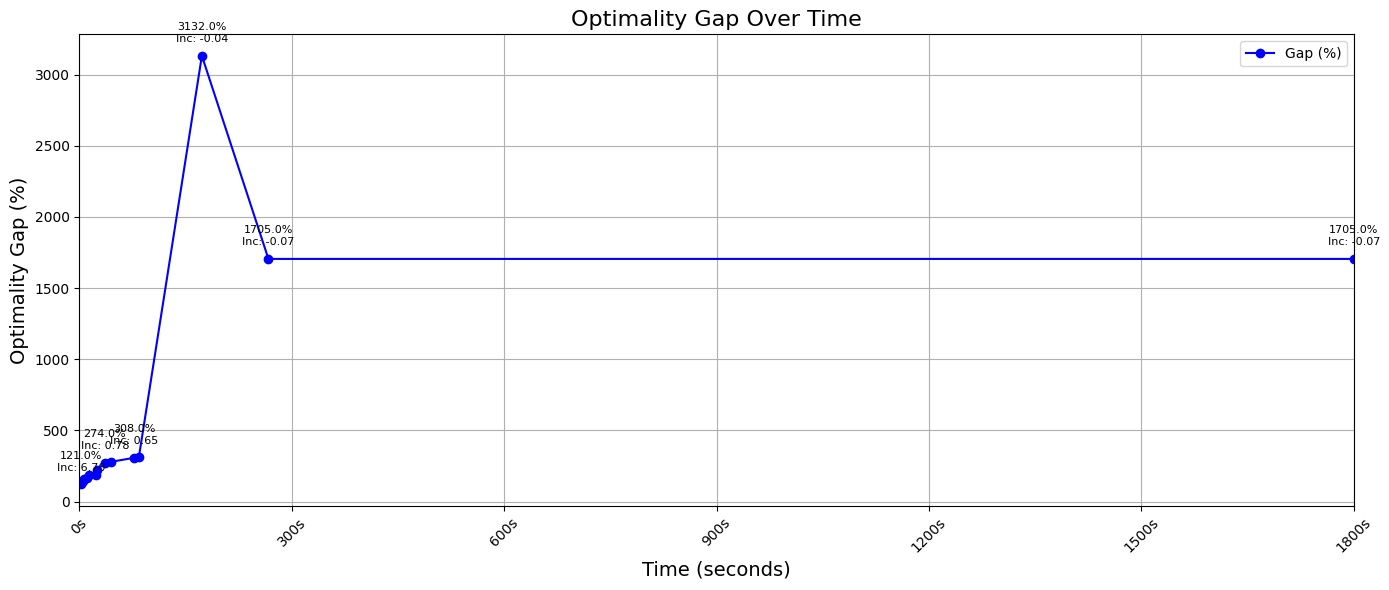

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Paste your log text as a multi-line string (shortened here for brevity)
log_lines = """
     0     0   -1.37934    0   86          -   -1.37934      -     -    1s
H    0     0                       9.1022067   -1.37934   115%     -    2s
H    0     0                       7.9439396   -1.37934   117%     -    2s
H    0     0                       7.0714471   -1.37934   120%     -    2s
     0     0   -1.37932    0  100    7.07145   -1.37932   120%     -    2s
H    0     0                       6.7631440   -1.37932   120%     -    2s
H    0     0                       6.7004344   -1.37932   121%     -    2s
     0     0   -1.37932    0  100    6.70043   -1.37932   121%     -    2s
     0     0   -1.37932    0   92    6.70043   -1.37932   121%     -    3s
H    0     0                       3.9429089   -1.37932   135%     -    4s
     0     0   -1.37932    0   92    3.94291   -1.37932   135%     -    4s
     0     0   -1.37932    0   82    3.94291   -1.37932   135%     -    4s
H    0     0                       3.3116100   -1.37932   142%     -    5s
     0     0   -1.37932    0   82    3.31161   -1.37932   142%     -    5s
     0     0   -1.37932    0   82    3.31161   -1.37932   142%     -    5s
     0     0   -1.37932    0   82    3.31161   -1.37932   142%     -    5s
     0     0   -1.37909    0   82    3.31161   -1.37909   142%     -    5s
H    0     0                       2.7568066   -1.37909   150%     -    6s
     0     0   -1.37909    0   82    2.75681   -1.37909   150%     -    6s
     0     0   -1.37908    0   82    2.75681   -1.37908   150%     -    6s
     0     0   -1.37908    0   82    2.75681   -1.37908   150%     -    6s
H    0     0                       2.2145706   -1.37908   162%     -    6s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    7s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    7s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    7s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    7s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    8s
     0     0   -1.37908    0   82    2.21457   -1.37908   162%     -    8s
     0     2   -1.36233    0   82    2.21457   -1.36233   162%     -    9s
    11    16   -1.36233    4   87    2.21457   -1.36233   162%  70.4   10s
H   27    32                       2.1126834   -1.36233   164%  62.0   11s
H   60    61                       2.0670122   -1.36233   166%  64.4   13s
H   61    61                       1.7134132   -1.36233   180%  63.5   13s
H   62    61                       1.5741606   -1.36233   187%  63.3   13s
   105   101   -1.35467   26   78    1.57416   -1.36233   187%  50.9   15s
   183   160   -1.35462   41   73    1.57416   -1.36233   187%  39.6   20s
H  262   216                       1.5582901   -1.36233   187%  35.8   23s
H  264   216                       1.5445651   -1.36233   188%  36.1   23s
   297   257 infeasible   56         1.54457   -1.36233   188%  36.7   25s
H  300   257                       1.0989670   -1.36233   224%  36.6   25s
   496   398   -1.18960   34   72    1.09897   -1.36233   224%  33.5   31s
   579   490   -0.62935   55   51    1.09897   -1.36233   224%  33.7   36s
H  591   490                       0.7836841   -1.36233   274%  33.2   36s
   619   500   -0.62932   68   68    0.78368   -1.36233   274%  33.7   44s
H  626   500                       0.7599295   -1.36233   279%  33.6   44s
   629   504   -0.62932   74   70    0.75993   -1.36233   279%  33.7   48s
   690   613 infeasible   93         0.75993   -1.36233   279%  33.4   50s
   872   727   -1.35392   24   62    0.75993   -1.36233   279%  31.2   55s
  1137   960 infeasible   26         0.75993   -1.36233   279%  29.9   60s
  1223   961   -0.88526  120   82    0.75993   -1.36233   279%  30.0   66s
  1228   964   -0.73369   57   82    0.75993   -1.36233   279%  29.8   72s
  1248   983   -1.36123   19   91    0.75993   -1.36123   279%  33.9   75s
H 1256   939                       0.7435998   -1.36123   283%  34.1   77s
H 1259   892                       0.6542953   -1.36123   308%  34.3   77s
  1306   914   -1.29271   26   71    0.65430   -1.36123   308%  36.6   80s
H 1343   896                       0.6379656   -1.36123   313%  38.1   84s
  1347   899   -1.27117   32   74    0.63797   -1.36123   313%  38.0   86s
  1426   949   -0.73383   45   70    0.63797   -1.36123   313%  40.9   98s
  1477   991   -0.84353   56   63    0.63797   -1.36123   313%  42.5  100s
  1549  1025   -0.84353   65   65    0.63797   -1.36123   313%  43.6  105s
  1637  1106   -0.80820   78   56    0.63797   -1.36123   313%  46.6  110s
  1791  1188   -0.66409  105   76    0.63797   -1.36123   313%  50.8  115s
  1943  1265   -0.66408  127   59    0.63797   -1.36123   313%  56.4  122s
  1962  1303   -0.00463  131   62    0.63797   -1.36123   313%  57.0  126s
  2106  1395    0.02069  157   47    0.63797   -1.36123   313%  59.7  131s
  2281  1497    0.02074  183   49    0.63797   -1.36123   313%  61.8  145s
  2367  1527   -1.36078   24  102    0.63797   -1.36123   313%  61.9  150s
  2512  1588   -0.85267   40   57    0.63797   -1.36123   313%  62.8  155s
  2629  1626   -0.87469   52   52    0.63797   -1.36123   313%  64.5  160s
  2770  1707   -1.35295   34   93    0.63797   -1.36123   313%  64.1  166s
  2945  1792   -1.32901   69   67    0.63797   -1.36123   313%  62.4  173s
H 2958  1469                      -0.0421228   -1.36123  3132%  62.1  173s
  3001  1597   -1.32900   83   80   -0.04212   -1.36123  3132%  61.5  176s
  3327  1762   -0.38472  161   39   -0.04212   -1.36123  3132%  59.1  182s
  3506  1839   -1.14723   42   63   -0.04212   -1.36123  3132%  58.4  185s
  3843  2143   -0.68064  112   31   -0.04212   -1.36123  3132%  57.2  192s
  4086  2256   -0.83561   37   58   -0.04212   -1.36123  3132%  56.1  195s
  4494  2621   -1.30479   41   66   -0.04212   -1.36123  3132%  56.8  203s
  4716  2851 infeasible  102        -0.04212   -1.36123  3132%  56.2  206s
  5007  3122   -1.15972   50   84   -0.04212   -1.36123  3132%  55.2  210s
  5681  3649   -0.49440   68   72   -0.04212   -1.35483  3116%  52.6  218s
  6038  3810   -1.21764   37   66   -0.04212   -1.35394  3114%  51.7  223s
  6254  4071   -0.28664   35   63   -0.04212   -1.35386  3114%  51.3  227s
  6610  4350   -0.69975   44   80   -0.04212   -1.35295  3112%  50.8  232s
  6993  4639   -1.31536   31   78   -0.04212   -1.35295  3112%  50.5  237s
  7374  4921   -0.60721   65   77   -0.04212   -1.35292  3112%  50.1  242s
  7784  5175   -0.27009   85   74   -0.04212   -1.35233  3110%  49.8  249s
  8129  5527   -0.64501   43   64   -0.04212   -1.35213  3110%  49.5  255s
  8668  5885   -1.31869   23   82   -0.04212   -1.35138  3108%  48.7  261s
H 9099  6207                      -0.0747832   -1.34994  1705%  47.9  267s
  9548  6577   -0.15454   65   69   -0.07478   -1.34980  1705%  47.5  274s
 10037  6917   -0.28679  190   27   -0.07478   -1.34804  1703%  46.7  281s
 10496  7293   -0.97821   85   52   -0.07478   -1.34667  1701%  46.8  291s
 11039  7494   -1.03220   65   77   -0.07478   -1.34665  1701%  47.6  297s
 11438  7568   -0.29944   63   57   -0.07478   -1.34665  1701%  47.5  305s
 11563  7864   -0.12190   75   51   -0.07478   -1.34627  1700%  47.5  313s
 11988  8176   -1.28574   27   74   -0.07478   -1.34327  1696%  47.6  320s
H12101  8167                      -0.0811034   -1.34327  1556%  47.6  320s
 12367  8555   -1.20061   34   91   -0.08110   -1.34222  1555%  47.4  327s
 12941  8873   -1.25282   42   87   -0.08110   -1.34222  1555%  47.2  333s
 13394  9282   -0.63304   69   54   -0.08110   -1.34212  1555%  47.3  339s
 13946  9570   -1.06188   84   49   -0.08110   -1.34209  1555%  46.7  345s
 14432  9812   -0.38812   93   52   -0.08110   -1.34207  1555%  46.9  352s
 14880 10030   -0.70316   76   69   -0.08110   -1.34149  1554%  46.7  358s
 15144 10515   -1.04148   76   59   -0.08110   -1.34065  1553%  46.4  364s
 15783 10769   -1.32893   29   81   -0.08110   -1.33966  1552%  45.6  370s
H16118 10896                      -0.0925721   -1.33949  1347%  45.5  377s
H16212 10830                      -0.1103593   -1.33937  1114%  45.5  377s
 16344 11152   -1.33530   32   95   -0.11036   -1.33898  1113%  45.6  382s
 16832 11451   -0.76250   61   52   -0.11036   -1.33815  1113%  45.6  388s
 17321 11799   -0.89934   51   63   -0.11036   -1.33662  1111%  45.6  394s
 17828 12015   -0.70043   41   38   -0.11036   -1.33662  1111%  45.5  400s
 18153 12332   -0.85510   43   68   -0.11036   -1.33661  1111%  45.5  405s
 18639 12494   -0.86403   56   63   -0.11036   -1.33658  1111%  45.5  415s
 18831 12756   -1.16194   60   99   -0.11036   -1.33658  1111%  45.6  421s
 19307 12998 infeasible   79        -0.11036   -1.33658  1111%  45.6  428s
 19697 13368     cutoff   44        -0.11036   -1.33657  1111%  45.4  434s
 20223 13403   -0.34774   46   78   -0.11036   -1.33593  1111%  45.3  442s
 20287 13682   -0.34263   47   72   -0.11036   -1.33593  1111%  45.2  449s
 20671 14121   -1.27607   39   58   -0.11036   -1.33574  1110%  45.2  454s
 21212 14369 infeasible   55        -0.11036   -1.33574  1110%  44.8  533s
 21583 14601   -0.58607   58   69   -0.11036   -1.33573  1110%  44.7  542s
 21940 14997   -0.32865   84   60   -0.11036   -1.33558  1110%  44.6  552s
 22528 15658   -0.32286   50   57   -0.11036   -1.33485  1110%  44.5  560s
 23366 16169   -1.29917   32   83   -0.11036   -1.33485  1110%  43.9  566s
 24016 16619   -1.33484   38   88   -0.11036   -1.33485  1110%  43.6  572s
 24599 16930   -0.78965   85   64   -0.11036   -1.33484  1110%  43.5  578s
 25011 17186   -0.16568   52   44   -0.11036   -1.33484  1110%  43.5  583s
 25438 17521   -0.91814   56   86   -0.11036   -1.33482  1110%  43.6  589s
 25879 17756   -1.24529   63   82   -0.11036   -1.33468  1109%  43.7  594s
 26228 17830   -1.22541   29   70   -0.11036   -1.33403  1109%  43.9  603s
 26363 18082 infeasible   54        -0.11036   -1.33347  1108%  43.9  609s
 26721 18442   -0.80957   64   50   -0.11036   -1.33336  1108%  43.7  614s
 27203 18637   -1.26361   34   78   -0.11036   -1.33308  1108%  43.8  618s
 27454 18850   -0.85305   51   72   -0.11036   -1.33304  1108%  43.7  631s
 27744 19098   -0.17467   83   62   -0.11036   -1.33291  1108%  43.6  638s
 28135 19470   -1.22254   37   68   -0.11036   -1.33191  1107%  43.7  643s
 28648 19613   -0.32114   69   57   -0.11036   -1.33184  1107%  43.6  648s
 28847 19628   -1.31372   33   73   -0.11036   -1.33184  1107%  43.7  658s
 28862 19893   -1.31371   37   67   -0.11036   -1.33183  1107%  43.8  664s
 29278 19894 infeasible   98        -0.11036   -1.33174  1107%  43.9  675s
 29283 20234 infeasible   99        -0.11036   -1.33169  1107%  43.9  681s
 29771 20447   -0.70913   86   78   -0.11036   -1.33137  1106%  43.7  686s
 30107 20516   -0.25255   41   38   -0.11036   -1.33122  1106%  43.7  693s
 30216 20800   -0.13668   45   31   -0.11036   -1.33115  1106%  43.7  699s
 30607 21009   -1.13075   48   73   -0.11036   -1.33033  1105%  43.8  704s
 30907 21276   -0.61822   47   53   -0.11036   -1.33032  1105%  43.9  710s
 31329 21507   -0.97385   76   77   -0.11036   -1.33008  1105%  43.9  716s
 31728 21958 infeasible   56        -0.11036   -1.32986  1105%  43.9  725s
 32368 22127   -0.19048   63   43   -0.11036   -1.32918  1104%  43.8  730s
 32656 22305   -0.74341   73   66   -0.11036   -1.32901  1104%  43.9  735s
 32995 22497   -1.21334   82   75   -0.11036   -1.32900  1104%  44.0  740s
 33332 22690   -0.94550   48   85   -0.11036   -1.32897  1104%  44.1  746s
 33677 22998   -0.96247   73   69   -0.11036   -1.32892  1104%  44.2  752s
 34132 23222   -1.11081   55   69   -0.11036   -1.32852  1104%  44.3  758s
 34585 23458   -0.71689   61   88   -0.11036   -1.32843  1104%  44.4  763s
 34985 23539   -0.73611   89   67   -0.11036   -1.32843  1104%  44.3  770s
 35084 23784   -0.73611  121   65   -0.11036   -1.32816  1103%  44.3  776s
 35451 24008   -0.75664   49   63   -0.11036   -1.32767  1103%  44.4  782s
 35854 24276   -1.26778   52   48   -0.11036   -1.32693  1102%  44.4  789s
 36229 24545   -0.59097   61   73   -0.11036   -1.32678  1102%  44.5  795s
 36611 24769   -0.68961   61   65   -0.11036   -1.32678  1102%  44.4  808s
 36919 25046     cutoff   82        -0.11036   -1.32658  1102%  44.3  815s
 37343 25107   -1.18904   44   62   -0.11036   -1.32616  1102%  44.4  825s
 37427 25450   -0.30567   65   52   -0.11036   -1.32608  1102%  44.4  833s
 37904 25768   -0.42447   83   55   -0.11036   -1.32577  1101%  44.3  840s
 38287 25998   -0.46226   79   52   -0.11036   -1.32553  1101%  44.5  847s
 38685 26336     cutoff   82        -0.11036   -1.32536  1101%  44.5  854s
 39234 26720   -0.75131   43   49   -0.11036   -1.32515  1101%  44.4  860s
 39780 27036   -0.39891   46   68   -0.11036   -1.32485  1100%  44.3  867s
 40314 27299   -0.87955   36   69   -0.11036   -1.32440  1100%  44.4  873s
 40814 27680   -0.12735   41   83   -0.11036   -1.32415  1100%  44.5  879s
 41364 27840   -0.78867  134   49   -0.11036   -1.32411  1100%  44.5  889s
 41577 28170   -0.78867  135   50   -0.11036   -1.32411  1100%  44.6  895s
 42067 28389   -0.70535   89   39   -0.11036   -1.32409  1100%  44.6  906s
 42446 28770   -0.65747   43   70   -0.11036   -1.32406  1100%  44.8  913s
 43058 29139   -0.97661   50   77   -0.11036   -1.32377  1100%  44.9  919s
 43573 29465   -0.57475   42   71   -0.11036   -1.32377  1100%  44.9  925s
 43989 29699   -1.19130   37   70   -0.11036   -1.32355  1099%  44.9  932s
 44282 30038   -0.88977   51   56   -0.11036   -1.32344  1099%  45.0  938s
 44709 30226   -0.87520   93   53   -0.11036   -1.32344  1099%  45.0  943s
 45200 30324   -0.63589  147   62   -0.11036   -1.32335  1099%  45.1  956s
 45312 30391   -0.16143   52   58   -0.11036   -1.32332  1099%  45.1  968s
 45433 30660   -0.85284   66   71   -0.11036   -1.32313  1099%  45.1  975s
 45829 30916 infeasible   48        -0.11036   -1.32273  1099%  45.0  986s
 46239 31276   -0.99026   77   47   -0.11036   -1.32271  1099%  44.9  992s
 46780 31637   -0.79257   36   65   -0.11036   -1.32263  1098%  44.9  999s
 47301 31933   -0.21391   52   69   -0.11036   -1.32222  1098%  45.0 1005s
 47770 32249   -0.74023  112   75   -0.11036   -1.32171  1098%  45.1 1012s
 48362 32504   -0.89888   64   65   -0.11036   -1.32158  1098%  45.1 1019s
 48713 32820   -0.20816   41   65   -0.11036   -1.32152  1097%  45.2 1025s
 49220 33111   -0.48713  104   56   -0.11036   -1.32136  1097%  45.2 1031s
 49687 33444   -0.40339   51   54   -0.11036   -1.32095  1097%  45.3 1037s
 50218 33710   -0.20515   41   55   -0.11036   -1.32028  1096%  45.3 1048s
 50610 34070   -0.67986   70   88   -0.11036   -1.32027  1096%  45.3 1054s
 51110 34340   -0.98159   54   56   -0.11036   -1.32027  1096%  45.4 1060s
 51548 34652   -1.16546   56   74   -0.11036   -1.32027  1096%  45.4 1067s
 51965 35084   -0.17087  112   51   -0.11036   -1.32027  1096%  45.4 1073s
 52487 35504   -0.80106   67   68   -0.11036   -1.32026  1096%  45.3 1082s
 53095 35602   -0.41781   86   76   -0.11036   -1.31922  1095%  45.3 1088s
 53292 35898   -0.72694   58   51   -0.11036   -1.31894  1095%  45.3 1094s
 53746 36109   -0.67724   68   88   -0.11036   -1.31864  1095%  45.3 1099s
 54077 36349   -1.27304   75   74   -0.11036   -1.31859  1095%  45.4 1106s
 54487 36431   -1.04316   66   75   -0.11036   -1.31850  1095%  45.4 1116s
 54641 36734   -0.43296   54   39   -0.11036   -1.31850  1095%  45.4 1122s
 55141 37026   -0.68142   52   77   -0.11036   -1.31850  1095%  45.5 1128s
 55651 37325   -0.34075   65   42   -0.11036   -1.31847  1095%  45.6 1134s
 56103 37616   -1.26088   29   63   -0.11036   -1.31822  1094%  45.7 1140s
 56541 37980   -0.68867   61   55   -0.11036   -1.31781  1094%  45.7 1146s
 57084 38383   -1.21470   43   70   -0.11036   -1.31781  1094%  45.6 1153s
 57608 38734   -0.60485  115   44   -0.11036   -1.31781  1094%  45.4 1159s
 58083 39074 infeasible   61        -0.11036   -1.31780  1094%  45.2 1165s
 58537 39177 infeasible   62        -0.11036   -1.31780  1094%  45.2 1171s
 58672 39506   -0.77293   53   65   -0.11036   -1.31780  1094%  45.3 1177s
 59171 39720     cutoff   95        -0.11036   -1.31772  1094%  45.3 1184s
 59486 40084   -0.57446   54   77   -0.11036   -1.31760  1094%  45.3 1189s
 59986 40358   -0.53442   80   53   -0.11036   -1.31756  1094%  45.3 1195s
 60410 40496   -0.84820   26   58   -0.11036   -1.31748  1094%  45.4 1202s
 60599 40739   -0.84282   46   71   -0.11036   -1.31725  1094%  45.4 1209s
 60959 41034   -0.22866   41   53   -0.11036   -1.31713  1093%  45.4 1214s
 61413 41388   -1.16350   41   72   -0.11036   -1.31684  1093%  45.5 1220s
 61901 41536 infeasible   47        -0.11036   -1.31674  1093%  45.5 1234s
 62138 41865   -0.40340   55   74   -0.11036   -1.31674  1093%  45.5 1241s
 62623 42238   -0.18288   53   67   -0.11036   -1.31674  1093%  45.4 1247s
 63149 42688   -0.86180   37   52   -0.11036   -1.31673  1093%  45.4 1257s
 63881 42744 infeasible   62        -0.11036   -1.31673  1093%  45.4 1262s
 63985 43017   -1.18121   40   65   -0.11036   -1.31673  1093%  45.4 1268s
 64409 43291   -1.03729   49   67   -0.11036   -1.31672  1093%  45.5 1273s
 64758 43523   -0.24442   76   60   -0.11036   -1.31672  1093%  45.5 1278s
 65122 43706   -0.73204   33   63   -0.11036   -1.31664  1093%  45.6 1285s
 65704 43881   -0.67499   71   82   -0.11036   -1.31636  1093%  45.6 1297s
 65740 44221   -0.67498  100   83   -0.11036   -1.31636  1093%  45.6 1303s
 66242 44524   -1.13506   39   65   -0.11036   -1.31601  1092%  45.6 1309s
 66721 44895 infeasible   54        -0.11036   -1.31574  1092%  45.6 1316s
 67228 45038   -1.24952   41   68   -0.11036   -1.31566  1092%  45.5 1321s
 67443 45325   -0.12435   43   47   -0.11036   -1.31549  1092%  45.5 1327s
 67892 45572   -0.80464   63   40   -0.11036   -1.31536  1092%  45.5 1333s
 68438 45779   -0.14450   45   60   -0.11036   -1.31497  1092%  45.5 1338s
 68746 46010   -1.29176   39   69   -0.11036   -1.31495  1092%  45.5 1350s
 69247 46259 infeasible   65        -0.11036   -1.31493  1091%  45.5 1355s
 69638 46599   -0.20002   78   40   -0.11036   -1.31475  1091%  45.5 1361s
 70088 46830   -1.15066   43   67   -0.11036   -1.31460  1091%  45.4 1366s
 70439 47154   -1.19421   62   71   -0.11036   -1.31419  1091%  45.4 1372s
 70926 47415   -0.98344   38   59   -0.11036   -1.31407  1091%  45.4 1378s
 71297 47678   -0.78751   45   56   -0.11036   -1.31387  1091%  45.4 1384s
 71653 47973   -0.16964   53   55   -0.11036   -1.31374  1090%  45.4 1390s
 72125 48271   -0.54034   37   64   -0.11036   -1.31372  1090%  45.3 1395s
 72572 48616   -1.23702   47   85   -0.11036   -1.31372  1090%  45.3 1402s
 73106 48839   -0.20327   52   58   -0.11036   -1.31371  1090%  45.2 1409s
 73463 49248   -0.26532   83   40   -0.11036   -1.31371  1090%  45.2 1418s
 74074 49562   -0.29185   89   45   -0.11036   -1.31369  1090%  45.1 1423s
 74515 49768   -0.60255  116   62   -0.11036   -1.31358  1090%  45.1 1428s
 74847 50043   -0.80440   79   43   -0.11036   -1.31347  1090%  45.0 1433s
 75263 50244   -0.75275   37   58   -0.11036   -1.31335  1090%  45.0 1438s
 75595 50492     cutoff   53        -0.11036   -1.31324  1090%  45.0 1443s
 75966 50773   -0.54423   54   50   -0.11036   -1.31308  1090%  45.0 1448s
 76421 51003   -0.69761   64   57   -0.11036   -1.31286  1090%  45.0 1453s
 76745 51202   -0.70293   73   74   -0.11036   -1.31265  1089%  45.0 1459s
 77043 51456   -0.81596   41   61   -0.11036   -1.31264  1089%  45.0 1464s
 77433 51748   -1.14940   67   73   -0.11036   -1.31253  1089%  45.0 1469s
 77848 51975 infeasible   46        -0.11036   -1.31229  1089%  45.0 1474s
 78232 52161   -0.20254   52   62   -0.11036   -1.31221  1089%  45.0 1480s
 78592 52301   -0.66215   51   62   -0.11036   -1.31199  1089%  45.1 1494s
 78824 52675   -0.17123   49   53   -0.11036   -1.31197  1089%  45.0 1499s
 79310 52950   -0.18331   83   58   -0.11036   -1.31196  1089%  45.0 1506s
 79733 53280   -1.17647   51   80   -0.11036   -1.31196  1089%  45.0 1512s
 80174 53562   -1.31039   31   88   -0.11036   -1.31189  1089%  45.0 1518s
 80625 53858   -0.69358   48   64   -0.11036   -1.31188  1089%  45.0 1524s
 81060 54133   -0.48115   44   55   -0.11036   -1.31188  1089%  45.0 1529s
 81494 54435 infeasible   73        -0.11036   -1.31133  1088%  45.0 1535s
 81967 54695   -0.84047   39   52   -0.11036   -1.31126  1088%  45.0 1542s
 82431 55028   -0.59834   55   44   -0.11036   -1.31126  1088%  44.9 1547s
 82930 55314   -0.26846   79   69   -0.11036   -1.31111  1088%  44.9 1552s
 83378 55691   -0.88840   40   58   -0.11036   -1.31095  1088%  44.9 1558s
 83898 55992   -0.78652   44   70   -0.11036   -1.31092  1088%  44.8 1567s
 84374 56264   -0.34080   85   58   -0.11036   -1.31091  1088%  44.9 1574s
 84827 56559     cutoff   88        -0.11036   -1.31085  1088%  44.9 1580s
 85213 56938   -0.51052   74   55   -0.11036   -1.31081  1088%  44.9 1586s
 85733 57321   -0.48794   78   46   -0.11036   -1.31077  1088%  44.9 1592s
 86269 57604 infeasible   65        -0.11036   -1.31077  1088%  44.8 1598s
 86719 57921   -0.89121   25   70   -0.11036   -1.31077  1088%  44.7 1603s
 87182 58217   -0.39561   60   55   -0.11036   -1.31052  1088%  44.7 1608s
 87649 58467   -0.19767   41   39   -0.11036   -1.31044  1087%  44.7 1615s
 88005 58674   -0.78032   51   51   -0.11036   -1.31044  1087%  44.7 1621s
 88311 58964   -0.77927   61   50   -0.11036   -1.31043  1087%  44.7 1627s
 88759 59282   -0.34271   67   53   -0.11036   -1.31037  1087%  44.7 1633s
 89273 59588   -1.14312   59   85   -0.11036   -1.31031  1087%  44.6 1638s
 89769 59897   -0.59964   58   72   -0.11036   -1.31025  1087%  44.6 1644s
 90220 60177   -0.25513   63   60   -0.11036   -1.31020  1087%  44.6 1650s
 90695 60474   -0.45469   84   46   -0.11036   -1.31020  1087%  44.6 1655s
 91110 60716   -0.25048   67   41   -0.11036   -1.31020  1087%  44.6 1661s
 91536 60942   -0.92853   65   81   -0.11036   -1.31020  1087%  44.7 1666s
 91857 61238   -0.27831  138   52   -0.11036   -1.31020  1087%  44.7 1671s
 92248 61241   -0.80819   85   58   -0.11036   -1.31019  1087%  44.7 1683s
 92252 61512   -0.80819   86   63   -0.11036   -1.31019  1087%  44.7 1689s
 92670 61800   -0.56439  119   50   -0.11036   -1.31019  1087%  44.7 1695s
 93166 62025   -0.58162   48   68   -0.11036   -1.31007  1087%  44.6 1700s
 93531 62266   -0.22704   61   48   -0.11036   -1.30988  1087%  44.7 1706s
 93888 62583   -0.55118   75   72   -0.11036   -1.30971  1087%  44.7 1711s
 94320 62725   -0.47784   55   65   -0.11036   -1.30971  1087%  44.7 1730s
 94552 63935   -0.65785   55   57   -0.11036   -1.30967  1087%  44.7 1753s
 96317 64347   -0.48215   81   63   -0.11036   -1.30945  1087%  44.6 1760s
 96956 64589   -0.78965   40   61   -0.11036   -1.30941  1086%  44.5 1766s
 97366 64883 infeasible   54        -0.11036   -1.30915  1086%  44.6 1772s
 97794 65143 infeasible   70        -0.11036   -1.30910  1086%  44.6 1779s
 98239 65447   -0.50164   60   63   -0.11036   -1.30897  1086%  44.6 1784s
 98764 65767   -0.85480   35   62   -0.11036   -1.30878  1086%  44.6 1790s
 99313 66115   -0.96494   45   83   -0.11036   -1.30876  1086%  44.6 1795s
 99833 66335   -0.77222   76   59   -0.11036   -1.30872  1086%  44.6 1800s
""".strip().splitlines()


data = []

# Parse the log lines
for line in log_lines:
    if line.strip().startswith('H'):
        parts = line.split()
        try:
            incumbent = float(parts[3])
            best_bound = float(parts[4])
            gap_str = parts[5].strip('%')
            gap = float(gap_str)
            time_str = parts[-1]
            time = int(time_str.strip('s'))
            data.append((time, gap, incumbent))
        except (IndexError, ValueError):
            continue

# Remove duplicates by time and sort
data_dict = {t: (g, inc) for t, g, inc in data}
data = sorted(data_dict.items())

# Extract times, gaps, incumbents
times = [t for t, _ in data]
gaps = [v[0] for _, v in data]
incumbents = [v[1] for _, v in data]

# Extend to 1800s using last known values
if times and times[-1] < 1800:
    times.append(1800)
    gaps.append(gaps[-1])
    incumbents.append(incumbents[-1])

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(times, gaps, marker='o', color='blue', label='Gap (%)')

# Annotate only significant changes with reduced clutter in early times
prev_gap = None
prev_inc = None
prev_time = -999

for t, g, inc in zip(times, gaps, incumbents):
    # Allow denser early annotations, sparser later ones
    if t <= 300:
        min_time_gap = 30
    elif t <= 900:
        min_time_gap = 60
    else:
        min_time_gap = 120

    gap_changed = prev_gap is None or abs(g - prev_gap) > 0.5
    inc_changed = prev_inc is None or inc != prev_inc
    far_enough = (t - prev_time) >= min_time_gap
    is_final = t == 1800

    if (gap_changed or inc_changed) and far_enough or is_final:
        ax.annotate(f"{g:.1f}%\nInc: {inc:.2f}", xy=(t, g), xytext=(0, 10),
                textcoords='offset points', ha='center', fontsize=8)

        prev_gap = g
        prev_inc = inc
        prev_time = t

# Set x-ticks: first, 300s interval, last
xticks = list(range(0, 1801, 300))
ax.set_xticks(xticks)
ax.set_xticklabels([f"{t}s" for t in xticks], rotation=45)

# Final formatting
ax.set_xlim(0, 1800)
ax.set_title("Optimality Gap Over Time", fontsize=16)
ax.set_xlabel("Time (seconds)", fontsize=14)
ax.set_ylabel("Optimality Gap (%)", fontsize=14)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()
